**Install conda env and activate it**

```
conda env create -f HIV_shadow.yml
```

```
conda activate HIV_shadow
```

**Import `python` modules**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **CHAPTER 0. PREPARATION**

## **Part 1. Working on server**

1. Connect to a server using `ssh`
2. Launch `Snakemake` pipeline (use `screen`)
3. Download `Kraken2` reports

```
scp username@host.com:/home/hiv_project_BI/reports/* \reports\
```

(It is conscious decision to hide server info, we are not stupid)

## **Part 2. Group data**

In [1]:
! mkdir HIV
! mkdir CTRL
! cp reports/kraken_report_CTRL/* CTRL/
! cp reports/kraken_report_HIV/* HIV/

# **CHAPTER 1. DATA PARSING**

## **Part 1. Create metadata**

Rename files. Delete `_kraken_report` from file names.

In [9]:
# Usage
# {path_to_script} {path_to_folder}
%run scripts/rename_files.py HIV/

In [3]:
# Usage
# {path_to_script} {path_to_folder}
%run scripts/rename_files.py CTRL/

Create `metadata.csv` based on the file names in `CTRL` and `HIV` folders

In [2]:
# Usage
# {path_to_script} {path_to_HIV_samples} {path_to_ctrl_samples} {output_file_name}
%run scripts/create_metadata.py HIV/ CTRL/ metadata.csv

Metadata written to metadata.csv


## **Part 2. Create counts file**

Install KrakenTools

In [5]:
! git clone https://github.com/jenniferlu717/KrakenTools.git

Cloning into 'KrakenTools'...


Create folders for files groupping

In [5]:
%%bash
mkdir ALL
mkdir ALL/txt
mkdir ALL/mpa

Copy kraken reports to the `ALL/txt` folder

In [6]:
%%bash
cp CTRL/* ALL/txt
cp HIV/* ALL/txt

Convert kraken reports in `ALL/txt` folder to MPA format and place files in `ALL/mpa` folder

In [8]:
# Usage
# {path_to_script} {path_to_txt_files} {path_to_output_mpa_files}
! ./scripts/run_kreport2mpa.sh ALL/txt ALL/mpa

Combine mpa files

In [3]:
# Usage
# {path_to_script} {path_to_mpa_files} {output_file_name}
%run KrakenTools/combine_mpa.py -i ALL/mpa/* -o ALL/COMBINED.txt

 Number of files to parse: 794
 Number of classifications to write: 4604
	4604 classifications printed


### **Part 2.1. Filter contaminants out from `ALL/COMBINED.txt` file**

We will filter out:
1. _Bradyrhizobium_ genus - the main villain in all DNA samples [1]
2. _Cutibacterium acnes_ - as it is the most common contaminant in blood cultures [2]
3. Bacteriophages

[1] https://pubmed.ncbi.nlm.nih.gov/25387460/<br>
[2] https://pubmed.ncbi.nlm.nih.gov/35612767/ - _Cutibacterium acnes_ can be non contaminant if we are talking about infections associated with implants

#### **Part 2.1.1. _Cutibacterium acnes_**

In [4]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "s__Cutibacterium_acnes"

Found keyword in line 2558
2553: d__Bacteria|p__Actinomycetota|c__Actinomycetes|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acidifaciens	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	2	0	0	0	0	0	0	1	0	2	2	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	1	0	3	1	0	1	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	1	0	0	0	0	0	0	0	0	1	0	1	0	1	0	0	0	0	1	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	

Line to delete: 2558

In [5]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "2558"

Lines 2558 have been deleted from ALL/COMBINED.txt.


#### **Part 2.1.2. Bacteriophages**

##### **Part 2.1.2.1. _Pseudomonas phage_ PPSC2**

In [6]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4456
4451: d__Viruses|k__Heunggongvirae|p__Peploviricota|c__Herviviricetes|o__Herpesvirales|f__Orthoherpesviridae|g__Cytomegalovirus|s__Cytomegalovirus_humanbeta5	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

Lines to delete: 4455, 4456

In [7]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4455, 4456"

Lines 4455, 4456 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.2. _Streptococcus phage_ CHPC1042 & _Escherichia phage vB EcoP_ WFI101126**

In [8]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4465
4460: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Schitoviridae	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

Lines to delete: 4465, 4466, 4467

In [9]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4465, 4466, 4467"

Lines 4465, 4466, 4467 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.3. _Xanthomonas phage_ vB Xar IVIA-DoCa5 & _Stenotrophomonas phage_ vB SM ytsc ply2008005c**

In [10]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4472
4467: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Herelleviridae|g__Klumppvirus	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

Lines to delete: 4471, 4472, 4476

In [11]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4471, 4472, 4476"

Lines 4471, 4472, 4476 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.4. _Brochothrix phage_ BL3 & _Staphylococcus phage_ phiRS7**

In [12]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4480
4475: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Chaseviridae|g__Loessnervirus	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

Lines to delete: 4480, 4481

In [13]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4480, 4481"

Lines 4480, 4481 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.5. _Erwinia phage_ PEp14**

In [14]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4488
4483: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|g__Noxifervirus|s__Noxifervirus_noxifer	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

Lines to delete: 4488

In [15]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4488"

Lines 4488 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.6. _Streptococcus phage_ CHPC1152 & _Streptococcus phage_ P7132**

In [16]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Found keyword in line 4493
4488: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Straboviridae	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

Lines to delete: 4491, 4492, 4493, 4494, 4495

In [17]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL/COMBINED.txt "4491, 4492, 4493, 4494, 4495"

Lines 4491, 4492, 4493, 4494, 4495 have been deleted from ALL/COMBINED.txt.


##### **Part 2.1.2.7. Checking if there are phages remaining**

In [18]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL/COMBINED.txt "phage"

Keyword not found in the file.


### **Part 2.2. Leave only Viruses domain**

In [1]:
%%bash

grep -E "d__Viruses" ALL/COMBINED.txt > ALL/VIRUSES.txt

# **CHAPTER 2. ALL FOUND ORGANISMS (`IonTorrent` only)**

## **Part 1. Getting `counts.csv` files**

### **Part 1.1. Parse `ALL/COMBINED.txt` file to counts files on several taxonomic levels**

In [ ]:
! mkdir counts

#### **Part 1.1.1. _`Species`_ level**

In [2]:
%%bash

grep -E "s__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__Homo_sapiens" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_species.txt

#### **Part 1.1.2. _`Genus`_ level**

In [3]:
%%bash

grep -E "g__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__Homo" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_genus.txt

#### **Part 1.1.3. _`Family`_ level**

In [4]:
%%bash

grep -E "f__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__Hominidae" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_family.txt

#### **Part 1.1.4. _`Order`_ level**

In [5]:
%%bash

grep -E "o__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| grep -v "o__Primates" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_order.txt

#### **Part 1.1.5. _`Class`_ level**

In [6]:
%%bash

grep -E "c__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| grep -v "o__" \
| grep -v "c__Mammalia" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_class.txt

#### **Part 1.1.6. _`Phylum`_ level**

In [7]:
%%bash

grep -E "p__" ALL/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| grep -v "o__" \
| grep -v "c__" \
| grep -v "p__Chordata" \
| grep -v "k__Fungi" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts/counts_phylum.txt

### **Part 1.2. Process counts files**

`processing_script` will do:
1. Return the 1st line with sample ids from `ALL/COMBINED.txt`
2. Delete '[X]__' and '_' from organisms names. [X] stands for taxonomic id (s - species, g - genus etc.)

In [8]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_species.txt

In [9]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_genus.txt

In [10]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_family.txt

In [11]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_order.txt

In [12]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_class.txt

In [13]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts/counts_phylum.txt

### **Part 1.3. Convert to `csv` file format**

`convert2csv` will do:
1. Take `counts_tax_lvl.txt` as the input
2. Give `counts_tax_lvl.csv` as the output

In [14]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_species.txt

C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\convert2csv.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

Data has been successfully converted and saved as 'counts/counts_species.csv'.


In [15]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_genus.txt

Data has been successfully converted and saved as 'counts/counts_genus.csv'.


In [16]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_family.txt

Data has been successfully converted and saved as 'counts/counts_family.csv'.


In [17]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_order.txt

Data has been successfully converted and saved as 'counts/counts_order.csv'.


In [18]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_class.txt

Data has been successfully converted and saved as 'counts/counts_class.csv'.


In [19]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts/counts_phylum.txt

Data has been successfully converted and saved as 'counts/counts_phylum.csv'.


### **Part 1.4. Filter contaminants once more**

The criteria about identifying and removing potential contamination in our data is based on the collection dates of the samples.

When analyzing cell-free DNA from various samples, ideally, the organisms (taxa) detected should be distributed somewhat randomly across different samples, depending on their source, environment, etc. If certain organisms appear only in samples that were collected on the same date, this pattern might suggest that those organisms weren't actually present in the samples originally but were introduced accidentally on that particular day—possibly during sample collection, processing, or handling.

**Key Points**:

- **Same Date, Same Taxon**: If we find that a specific organism (taxon) appears exclusively in samples that were all collected on the same date, and this organism does not appear in samples from other dates, it might indicate contamination.
- **Cross-Verification**: Check if this organism appears in other samples that are not from that specific date. If it doesn’t, this supports the contamination theory.
- **Removal of Suspected Data**: To ensure the integrity of data analysis, these suspected contaminated data points should be removed before performing further analysis.

Due to limitation this filtration will be performed only on _species_ level. Because we can filter out _Klebsiella variicola_ that was found only on 2022/03/03, but we cannot remove the whole _Klebsiella_ genus.

In [20]:
# Usage
# {path_to_script} {path_to_input_file} {path_to_output_file}
%run scripts/filter_possible_contaminants.py counts/counts_species.csv counts/counts_species_filtered.csv

## **Part 2. Descriptive statistics**

### **Part 2.1. _`Species`_ level**

count     794.000000
mean      163.846348
std       177.140120
min         0.000000
25%        51.000000
50%       102.000000
75%       218.000000
max      1440.000000
Name: total_counts, dtype: float64


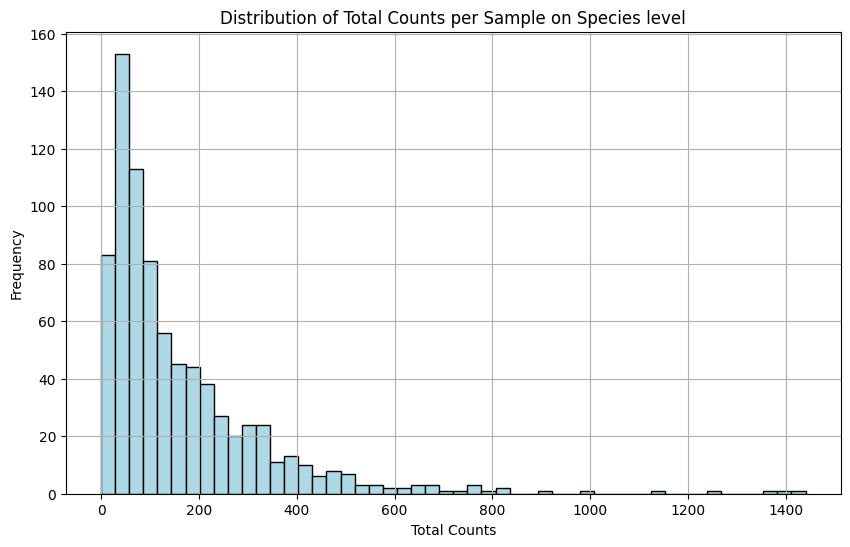

In [21]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_species_filtered.csv" Species

### **Part 2.2. _`Genus`_ level**

count     794.000000
mean      584.455919
std       663.058771
min         1.000000
25%       175.250000
50%       351.500000
75%       762.500000
max      7196.000000
Name: total_counts, dtype: float64


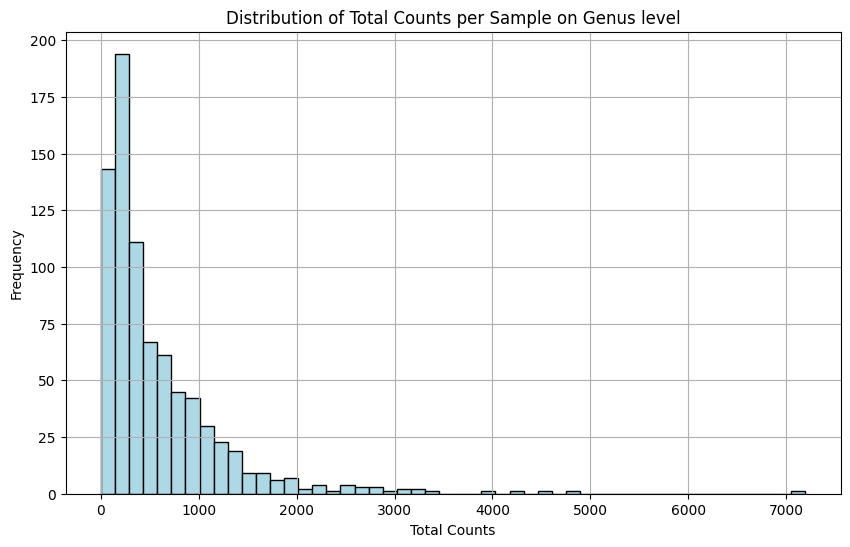

In [22]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_genus.csv" Genus

### **Part 2.3. _`Family`_ level**

count     794.000000
mean      614.845088
std       686.911022
min         1.000000
25%       186.000000
50%       374.000000
75%       800.500000
max      7297.000000
Name: total_counts, dtype: float64


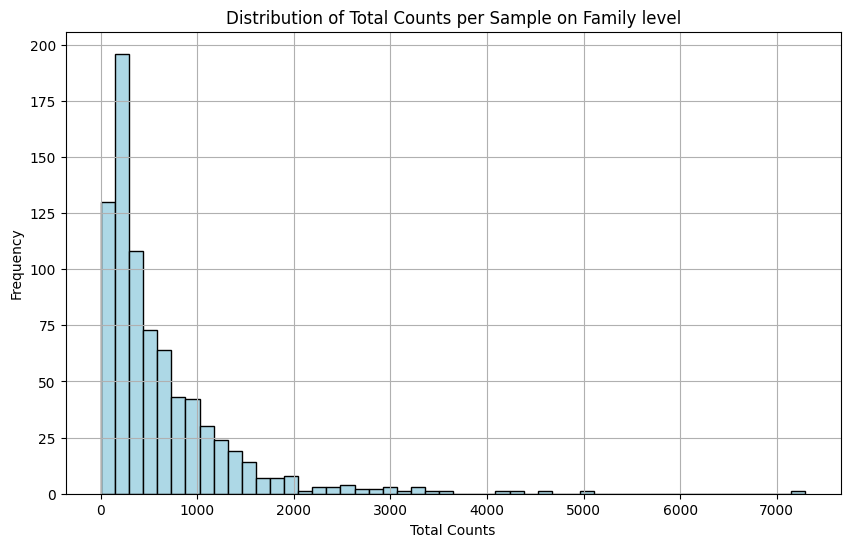

In [23]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_family.csv" Family

### **Part 2.4. _`Order`_ level**

count     794.000000
mean      631.285894
std       701.787049
min         2.000000
25%       192.000000
50%       387.500000
75%       823.250000
max      7463.000000
Name: total_counts, dtype: float64


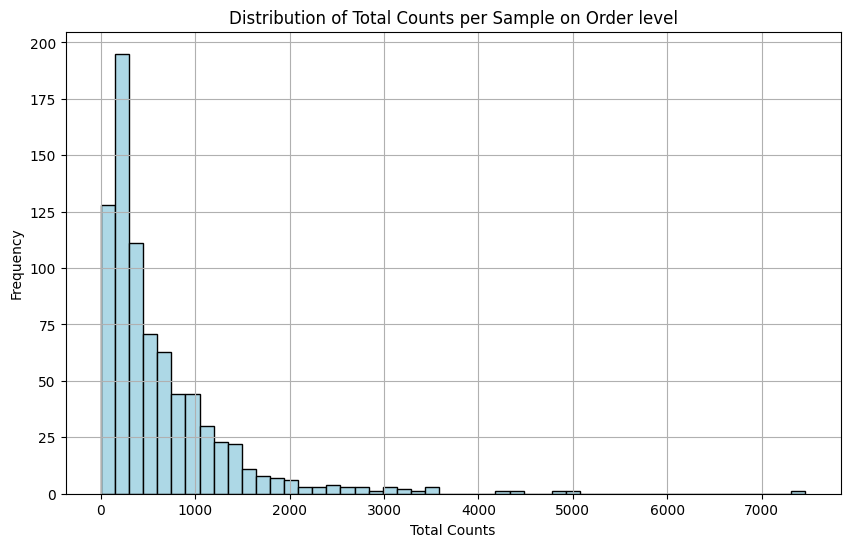

In [24]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_order.csv" Order

### **Part 2.5. _`Class`_ level**

count     794.000000
mean      667.704030
std       734.200925
min         2.000000
25%       208.000000
50%       413.000000
75%       871.750000
max      7755.000000
Name: total_counts, dtype: float64


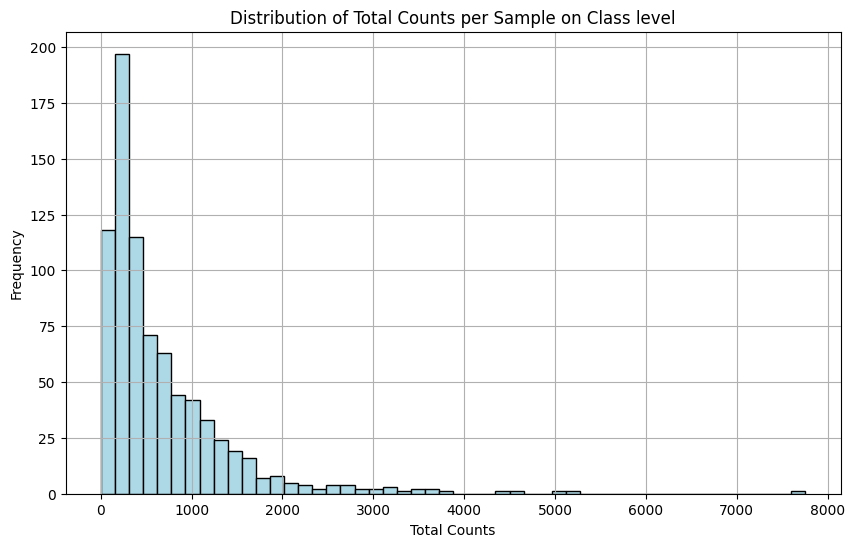

In [25]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_class.csv" Class

### **Part 2.6. _`Phylum`_ level**

count     794.000000
mean      685.007557
std       747.768354
min         3.000000
25%       216.250000
50%       428.000000
75%       891.750000
max      7816.000000
Name: total_counts, dtype: float64


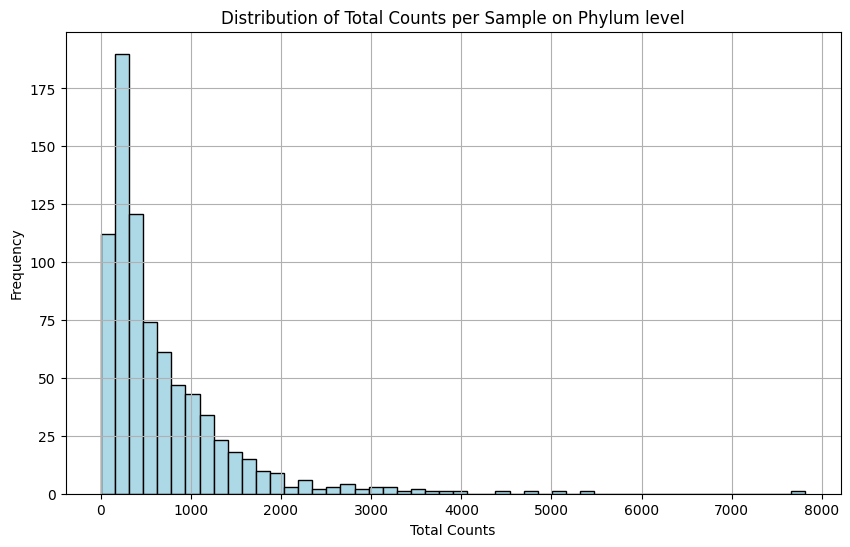

In [26]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts/counts_phylum.csv" Phylum

## **Part 3. Comparative statistics**

### **Part 3.1. Differential Abundance**

`MaAsLin2` is the next generation of `MaAsLin` (Microbiome Multivariable Association with Linear Models).

`MaAsLin2` is comprehensive R package for efficiently determining multivariable association between clinical metadata and microbial meta-omics features. `MaAsLin2` relies on general linear models to accommodate most modern epidemiological study designs, including cross-sectional and longitudinal, along with a variety of filtering, normalization, and transform methods.

In [ ]:
! mkdir MaAsLin2_results

#### **Part 3.1.1. _`Species`_ level**

In [27]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_species_filtered.csv MaAsLin2_results/species

[1] "Warning: Deleting existing log file: MaAsLin2_results/species/maaslin2.log"
2024-05-08 12:22:24.324537 INFO::Writing function arguments to log file
2024-05-08 12:22:24.399134 INFO::Verifying options selected are valid
2024-05-08 12:22:24.478947 INFO::Determining format of input files
2024-05-08 12:22:24.48444 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:22:24.549392 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:22:24.553342 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:22:24.556063 INFO::Total samples in data: 794
2024-05-08 12:22:24.558723 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:22:24.622613 INFO::Total filtered features: 0
2024-05-08 12:22:24.625928 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:22:24.817509 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:22:24.820481 IN

In [28]:
MaAsLin2_results_species = pd.read_csv('MaAsLin2_results/species/significant_results.tsv', sep='\t')
MaAsLin2_results_species

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Bradyrhizobium.sp..BTAi1,HIV_status,positive,5.495470,0.366054,794,264,5.120272e-45,1.051192e-41
1,Ralstonia.insidiosa,HIV_status,positive,3.183823,0.250293,794,63,7.304045e-34,7.497602e-31
2,Bradyrhizobium.sp..UASWS1016,HIV_status,positive,0.146365,0.020324,794,3,1.385667e-12,9.482584e-10
3,Enhydrobacter.sp.,HIV_status,positive,0.229193,0.032315,794,3,2.921409e-12,1.499413e-09
4,Hydrogenophilus.thermoluteolus,HIV_status,positive,-3.237179,0.472471,794,555,1.467470e-11,6.025431e-09
...,...,...,...,...,...,...,...,...,...
84,Rothia.aeria,HIV_status,positive,-0.834596,0.302355,794,282,5.907984e-03,1.426952e-01
85,Staphylococcus.haemolyticus,HIV_status,positive,-0.912043,0.334540,794,190,6.547271e-03,1.562971e-01
86,Psychrobacter.sp..WB2,HIV_status,positive,-0.795060,0.292164,794,219,6.645689e-03,1.568230e-01
87,Streptococcus.sp..S1,HIV_status,positive,0.107400,0.040594,794,4,8.313550e-03,1.939513e-01


#### **Part 3.1.2. _`Genus`_ level**

In [29]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_genus.csv MaAsLin2_results/genus

[1] "Warning: Deleting existing log file: MaAsLin2_results/genus/maaslin2.log"
2024-05-08 12:23:42.281899 INFO::Writing function arguments to log file
2024-05-08 12:23:42.347182 INFO::Verifying options selected are valid
2024-05-08 12:23:42.391285 INFO::Determining format of input files
2024-05-08 12:23:42.39482 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:23:42.422809 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:23:42.426975 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:23:42.429786 INFO::Total samples in data: 794
2024-05-08 12:23:42.433281 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:23:42.459666 INFO::Total filtered features: 0
2024-05-08 12:23:42.46291 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:23:42.559911 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:23:42.564677 INFO:

In [30]:
MaAsLin2_results_genus = pd.read_csv('MaAsLin2_results/genus/significant_results.tsv', sep='\t')
MaAsLin2_results_genus

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Bradyrhizobium,HIV_status,positive,5.258736,0.461545,794,466,5.895817e-28,5.070403e-25
1,Acinetobacter,HIV_status,positive,-2.650696,0.241978,794,785,4.237796e-26,1.822252e-23
2,Staphylococcus,HIV_status,positive,-2.342502,0.223470,794,762,3.646671e-24,1.045379e-21
3,Ralstonia,HIV_status,positive,3.769887,0.370786,794,258,6.585066e-23,1.415789e-20
4,Moraxella,HIV_status,positive,-2.141072,0.245132,794,759,1.442447e-17,2.481009e-15
...,...,...,...,...,...,...,...,...,...
94,Bifidobacterium,HIV_status,positive,-0.638381,0.274576,794,166,2.032534e-02,1.839978e-01
95,Rhodopseudomonas,HIV_status,positive,1.021964,0.440320,794,283,2.054238e-02,1.840254e-01
96,Gulosibacter,HIV_status,positive,-0.452706,0.197114,794,98,2.189756e-02,1.925412e-01
97,Gordonia,HIV_status,positive,-0.815570,0.355226,794,326,2.194074e-02,1.925412e-01


#### **Part 3.1.3. _`Family`_ level**

In [31]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_family.csv MaAsLin2_results/family

[1] "Warning: Deleting existing log file: MaAsLin2_results/family/maaslin2.log"
2024-05-08 12:25:35.306994 INFO::Writing function arguments to log file
2024-05-08 12:25:35.354849 INFO::Verifying options selected are valid
2024-05-08 12:25:35.401467 INFO::Determining format of input files
2024-05-08 12:25:35.404447 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:25:35.423857 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:25:35.427595 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:25:35.430037 INFO::Total samples in data: 794
2024-05-08 12:25:35.432464 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:25:35.445832 INFO::Total filtered features: 0
2024-05-08 12:25:35.448563 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:25:35.477195 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:25:35.479924 IN

In [32]:
MaAsLin2_results_family = pd.read_csv('MaAsLin2_results/family/significant_results.tsv', sep='\t')
MaAsLin2_results_family

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Weeksellaceae,HIV_status,positive,-3.685286,0.306608,794,721,1.094341e-30,3.315852e-28
1,Moraxellaceae,HIV_status,positive,-2.359121,0.203280,794,790,7.221637e-29,1.094078e-26
2,Staphylococcaceae,HIV_status,positive,-2.402982,0.224636,794,763,4.884395e-25,3.699929e-23
3,Candidatus.Nanopelagicaceae,HIV_status,positive,0.541329,0.050481,794,10,3.818246e-25,3.699929e-23
4,Nitrobacteraceae,HIV_status,positive,4.476676,0.504426,794,633,4.611864e-18,2.794790e-16
...,...,...,...,...,...,...,...,...,...
62,Sphaerochaetaceae,HIV_status,positive,0.073899,0.035361,794,6,3.695214e-02,1.749453e-01
63,Pectobacteriaceae,HIV_status,positive,-0.603442,0.287585,794,271,3.619404e-02,1.749453e-01
64,Gemellaceae,HIV_status,positive,-0.593847,0.286371,794,152,3.843003e-02,1.791431e-01
65,Campylobacteraceae,HIV_status,positive,-0.610775,0.296271,794,131,3.957737e-02,1.816961e-01


#### **Part 3.1.4. _`Order`_ level**

In [33]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_order.csv MaAsLin2_results/order

[1] "Warning: Deleting existing log file: MaAsLin2_results/order/maaslin2.log"
2024-05-08 12:26:27.811901 INFO::Writing function arguments to log file
2024-05-08 12:26:27.860954 INFO::Verifying options selected are valid
2024-05-08 12:26:27.907365 INFO::Determining format of input files
2024-05-08 12:26:27.910383 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:26:27.920067 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:26:27.924022 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:26:27.926802 INFO::Total samples in data: 794
2024-05-08 12:26:27.929543 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:26:27.944617 INFO::Total filtered features: 0
2024-05-08 12:26:27.947363 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:26:27.961075 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:26:27.963617 INF

In [34]:
MaAsLin2_results_order = pd.read_csv('MaAsLin2_results/order/significant_results.tsv', sep='\t')
MaAsLin2_results_order

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Bacillales,HIV_status,positive,-2.440131,0.190043,794,769,2.044156e-34,2.943585e-32
1,Flavobacteriales,HIV_status,positive,-3.755636,0.294093,794,732,4.298281e-34,3.094763e-32
2,Moraxellales,HIV_status,positive,-2.370739,0.204047,794,790,6.321765e-29,3.034447e-27
3,Hyphomicrobiales,HIV_status,positive,2.711943,0.246510,794,775,2.697202e-26,9.709929e-25
4,Candidatus.Nanopelagicales,HIV_status,positive,0.535359,0.050001,794,10,4.455852e-25,1.283285e-23
5,Rhodobacterales,HIV_status,positive,-2.842583,0.320399,794,715,4.717607e-18,1.132226e-16
6,Lactobacillales,HIV_status,positive,-1.631148,0.209863,794,776,2.390624e-14,4.917855e-13
7,Burkholderiales,HIV_status,positive,1.483707,0.220127,794,779,3.044976e-11,5.480956e-10
8,Hydrogenophilales,HIV_status,positive,-2.760769,0.415494,794,555,5.654944e-11,9.047911e-10
9,Pseudomonadales,HIV_status,positive,-1.185177,0.179586,794,789,7.549477e-11,1.087125e-09


#### **Part 3.1.5. _`Class`_ level**

In [35]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_class.csv MaAsLin2_results/class

[1] "Warning: Deleting existing log file: MaAsLin2_results/class/maaslin2.log"
2024-05-08 12:28:46.876186 INFO::Writing function arguments to log file
2024-05-08 12:28:46.934199 INFO::Verifying options selected are valid
2024-05-08 12:28:46.979815 INFO::Determining format of input files
2024-05-08 12:28:46.982739 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:28:46.990944 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:28:46.994561 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:28:46.996999 INFO::Total samples in data: 794
2024-05-08 12:28:46.999447 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:28:47.005376 INFO::Total filtered features: 0
2024-05-08 12:28:47.008058 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:28:47.019167 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:28:47.029997 INF

In [36]:
MaAsLin2_results_class = pd.read_csv('MaAsLin2_results/class/significant_results.tsv', sep='\t')
MaAsLin2_results_class

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Flavobacteriia,HIV_status,positive,-3.726649,0.292256,794,732,5.258421e-34,3.628310e-32
1,Bacilli,HIV_status,positive,-1.925227,0.154504,794,786,1.133239e-32,3.909674e-31
2,Alphaproteobacteria,HIV_status,positive,1.592308,0.167093,794,793,1.876059e-20,4.314935e-19
3,Actinomycetes,HIV_status,positive,-0.600381,0.090615,794,793,6.385350e-11,8.811783e-10
4,Hydrogenophilia,HIV_status,positive,-2.737359,0.412835,794,555,6.183953e-11,8.811783e-10
5,Betaproteobacteria,HIV_status,positive,0.917272,0.171081,794,790,1.082808e-07,1.245229e-06
6,Bacteroidia,HIV_status,positive,-1.450134,0.308957,794,659,3.161813e-06,3.116644e-05
7,Tissierellia,HIV_status,positive,-1.560663,0.413511,794,286,1.725261e-04,1.488038e-03
8,Clostridia,HIV_status,positive,-1.383713,0.421401,794,415,1.069865e-03,8.202300e-03
9,Gammaproteobacteria,HIV_status,positive,-0.376881,0.119980,794,793,1.745123e-03,1.204135e-02


#### **Part 3.1.6. _`Phylum`_ level**

In [37]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts/counts_phylum.csv MaAsLin2_results/phylum

[1] "Warning: Deleting existing log file: MaAsLin2_results/phylum/maaslin2.log"
2024-05-08 12:29:08.221227 INFO::Writing function arguments to log file
2024-05-08 12:29:08.269581 INFO::Verifying options selected are valid
2024-05-08 12:29:08.315596 INFO::Determining format of input files
2024-05-08 12:29:08.31855 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 12:29:08.326127 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 12:29:08.329721 INFO::Filter data based on min abundance and min prevalence
2024-05-08 12:29:08.332275 INFO::Total samples in data: 794
2024-05-08 12:29:08.334707 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 12:29:08.339725 INFO::Total filtered features: 0
2024-05-08 12:29:08.342406 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 12:29:08.349823 INFO::Total filtered features with variance filtering: 0
2024-05-08 12:29:08.352576 INF

In [38]:
MaAsLin2_results_phylum = pd.read_csv('MaAsLin2_results/phylum/significant_results.tsv', sep='\t')
MaAsLin2_results_phylum

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Bacteroidota,HIV_status,positive,-2.887042,0.229147,794,770,2.640922e-33,1.056369e-31
1,Bacillota,HIV_status,positive,-1.807698,0.153379,794,789,1.177208e-29,2.354417e-28
2,Actinomycetota,HIV_status,positive,-0.612275,0.087245,794,794,4.841419e-12,6.455225e-11
3,Pseudomonadota,HIV_status,positive,0.437343,0.079973,794,794,6.084230e-08,6.084230e-07
4,Euryarchaeota,HIV_status,positive,-1.265582,0.419746,794,257,2.650828e-03,2.120663e-02
5,Mycoplasmatota,HIV_status,positive,0.069708,0.025087,794,3,5.588117e-03,3.725411e-02
6,Fusobacteriota,HIV_status,positive,-0.948752,0.360793,794,313,8.713607e-03,4.979204e-02
7,Cyanobacteriota,HIV_status,positive,-1.035614,0.403657,794,245,1.048328e-02,5.241640e-02
8,Deinococcota,HIV_status,positive,-0.987053,0.400645,794,414,1.396417e-02,6.206298e-02


### **Part 3.2. Visualization.**

#### **Part 3.2.1. Volcano-plot.**

Why volcano-plot?<br>
Because just look at the number of statistically significant differences on the levels from _species_ to _family_. It is impossible to display all of that on just 1 heatmap.

Please open `RStudio` and go through  `Volcano_plot/volcano.R` script.<br>
There are a lot of manual adjustments to the plots to make it executable.

##### **Part 3.2.1.1. _`Species`_ level**

![alt text](Volcano_plot/volcano_plot_species.png)

##### **Part 3.2.1.2. _`Genus`_ level**

![alt text](Volcano_plot/volcano_plot_genus.png)

##### **Part 3.2.1.3. _`Family`_ level**

![alt text](Volcano_plot/volcano_plot_family.png)

#### **Part 3.2.2. Heatmap.**

##### **Part 3.2.2.1. _`Order`_ level**

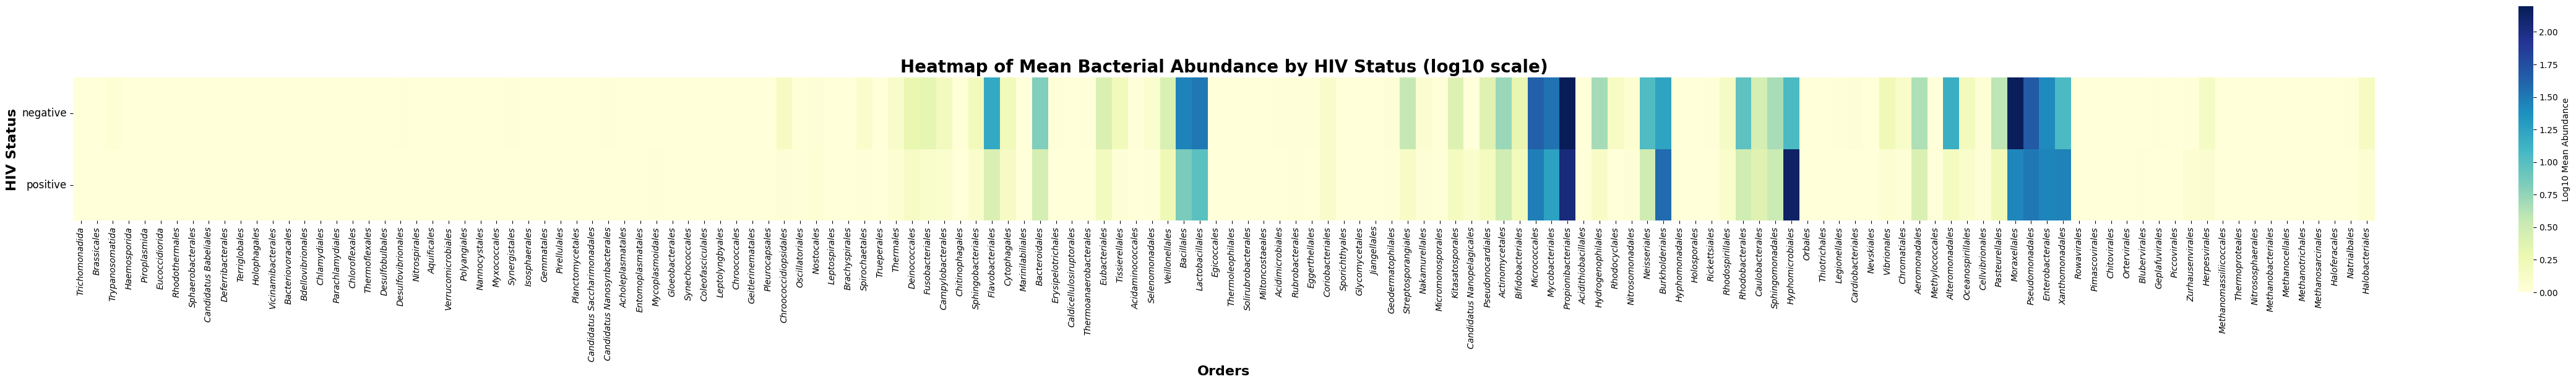

In [41]:
counts_df = pd.read_csv('counts/counts_order.csv')
metadata_df = pd.read_csv('metadata.csv')

merged_df = pd.merge(counts_df, metadata_df, left_on='Sample_id', right_on='sample_id')

merged_df.drop('Sample_id', axis=1, inplace=True)

mean_abundances = merged_df.groupby('HIV_status')[counts_df.columns[1:]].mean()

normalized_means = np.log10(mean_abundances + 1)

plt.figure(figsize=(60, 3))
sns.heatmap(normalized_means, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Log10 Mean Abundance', 'shrink': 2})
plt.title('Heatmap of Mean Bacterial Abundance by HIV Status (log10 scale)', fontsize=20, fontweight='bold')
plt.xlabel('Orders', fontsize=16, fontweight='bold')
plt.ylabel('HIV Status', fontsize=16, fontweight='bold')
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=90, fontsize=10, fontstyle='italic')
plt.show()

There are too many orders presented on the heatmap. We need to filter out orders that have log_mean_abundace < 0.1

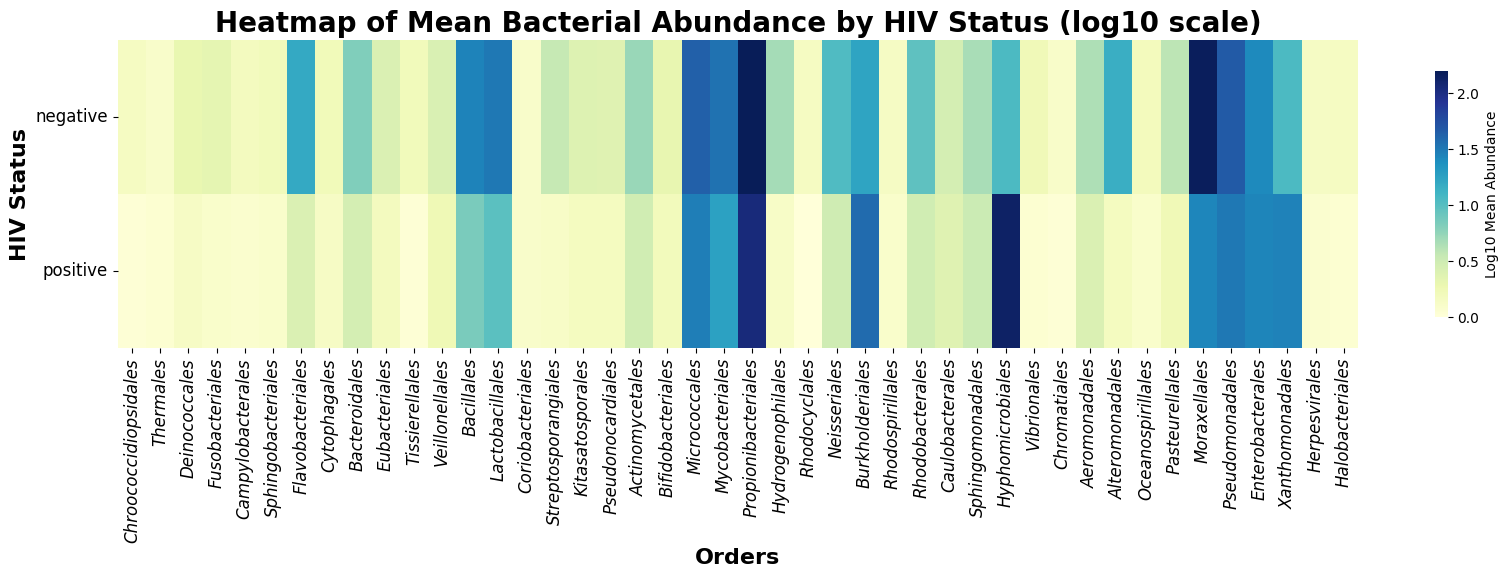

In [42]:
mean_abundances_full = merged_df.groupby('HIV_status')[counts_df.columns[1:]].mean()

log_mean_abundances_full = np.log10(mean_abundances_full + 1)

filtered_species_by_abundance = log_mean_abundances_full.columns[(log_mean_abundances_full > 0.1).any()]

filtered_counts_df_by_abundance = counts_df[['Sample_id'] + filtered_species_by_abundance.tolist()]

merged_df_filtered_abundance = pd.merge(filtered_counts_df_by_abundance, metadata_df, left_on='Sample_id', right_on='sample_id')

merged_df_filtered_abundance.drop(['Sample_id', 'sample_id'], axis=1, inplace=True)

mean_abundances_filtered_abundance = merged_df_filtered_abundance.groupby('HIV_status')[filtered_counts_df_by_abundance.columns[1:]].mean()

normalized_means_filtered_abundance = np.log10(mean_abundances_filtered_abundance + 1)

plt.figure(figsize=(20, 4))
sns.heatmap(normalized_means_filtered_abundance, cmap='YlGnBu', annot=False,
            cbar_kws={'label': 'Log10 Mean Abundance', 'shrink': 0.8})
plt.title('Heatmap of Mean Bacterial Abundance by HIV Status (log10 scale)', fontsize=20, fontweight='bold')
plt.xlabel('Orders', fontsize=16, fontweight='bold')
plt.ylabel('HIV Status', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=12, fontstyle='italic')
plt.yticks(rotation=0, fontsize=12)
plt.show()

##### **Part 3.2.2.1. _`Class`_ level**

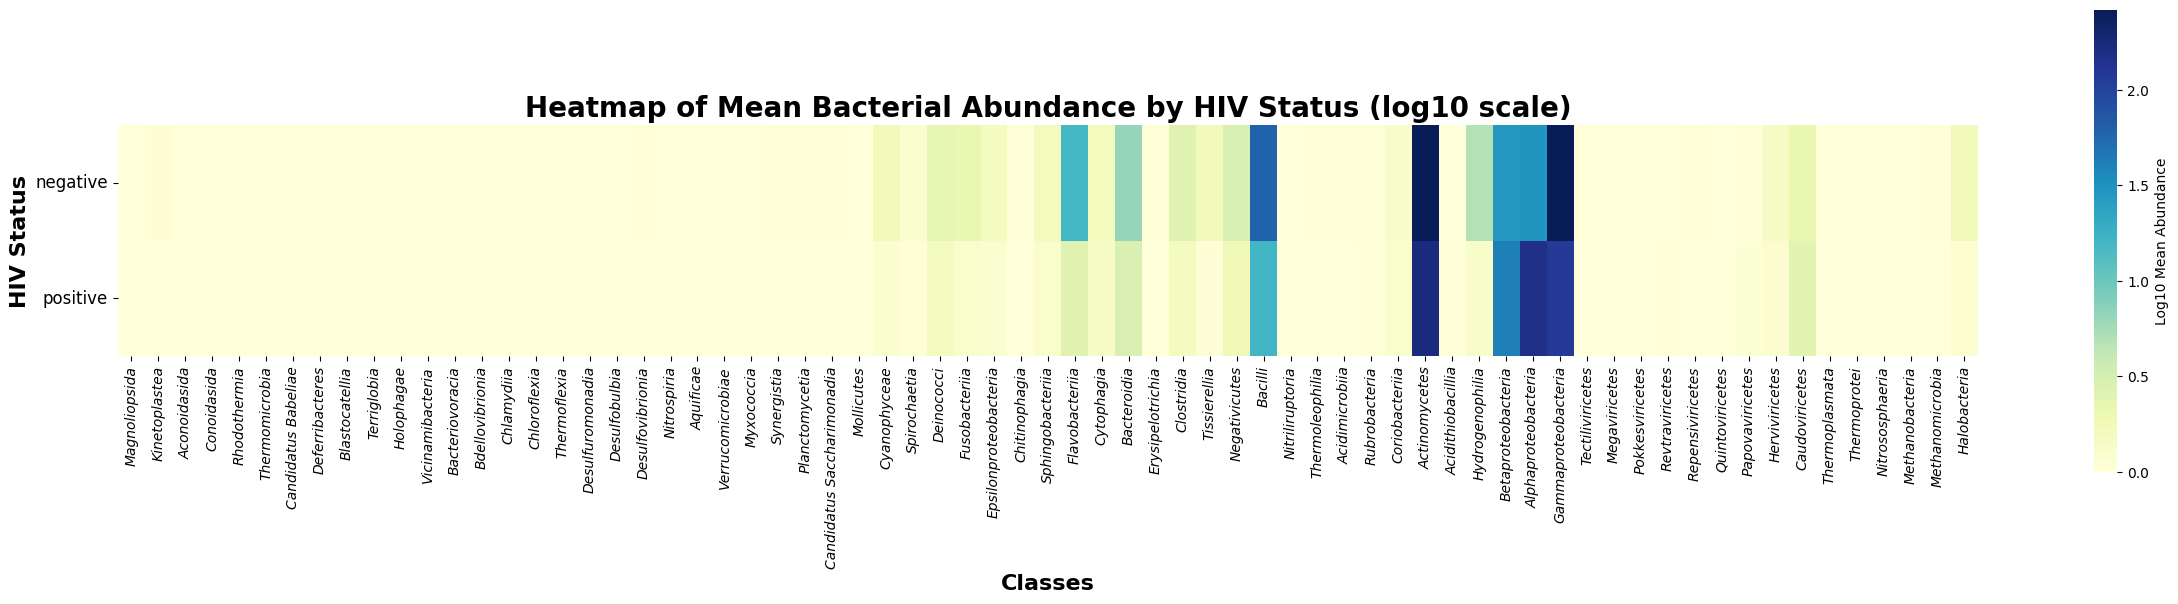

In [43]:
counts_df = pd.read_csv('counts/counts_class.csv')
metadata_df = pd.read_csv('metadata.csv')

merged_df = pd.merge(counts_df, metadata_df, left_on='Sample_id', right_on='sample_id')

merged_df.drop('Sample_id', axis=1, inplace=True)

mean_abundances = merged_df.groupby('HIV_status')[counts_df.columns[1:]].mean()

normalized_means = np.log10(mean_abundances + 1)

plt.figure(figsize=(30, 3))
sns.heatmap(normalized_means, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Log10 Mean Abundance', 'shrink': 2})
plt.title('Heatmap of Mean Bacterial Abundance by HIV Status (log10 scale)', fontsize=20, fontweight='bold')
plt.xlabel('Classes', fontsize=16, fontweight='bold')
plt.ylabel('HIV Status', fontsize=16, fontweight='bold')
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=90, fontsize=10, fontstyle='italic')
plt.show()

##### **Part 3.2.2.1. _`Phylum`_ level**

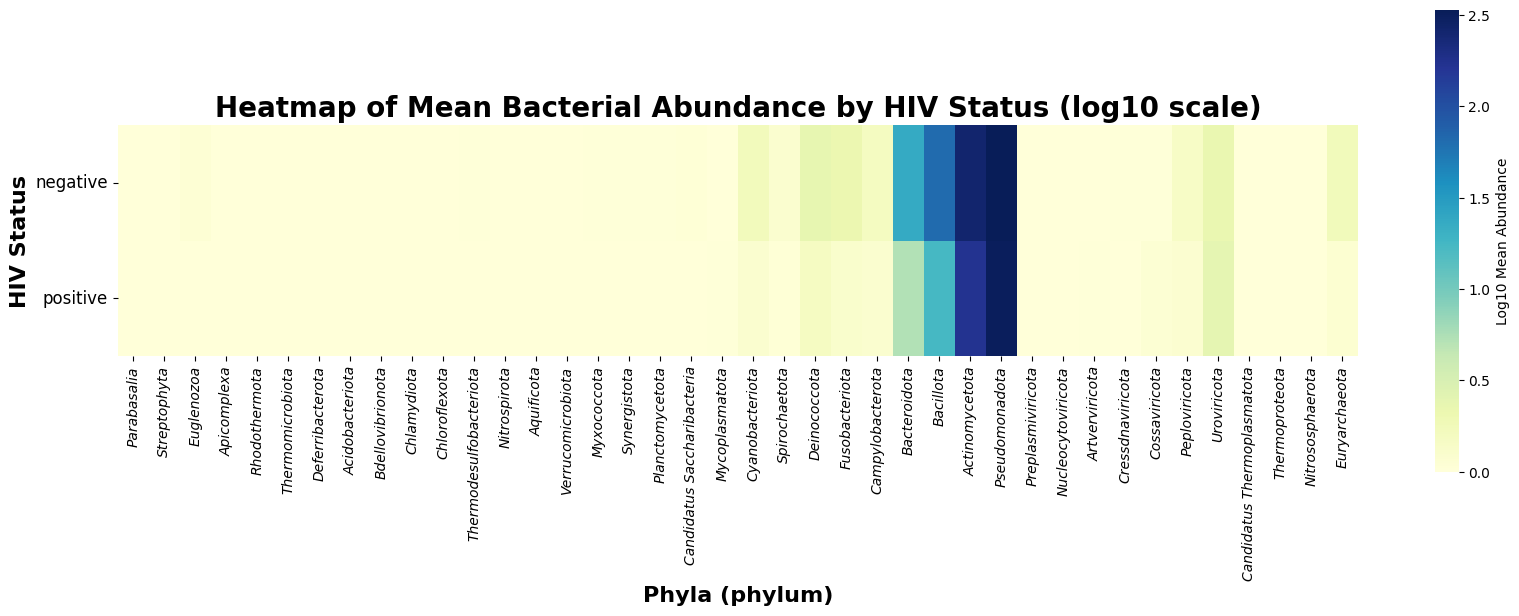

In [44]:
counts_df = pd.read_csv('counts/counts_phylum.csv')
metadata_df = pd.read_csv('metadata.csv')

merged_df = pd.merge(counts_df, metadata_df, left_on='Sample_id', right_on='sample_id')

merged_df.drop('Sample_id', axis=1, inplace=True)

mean_abundances = merged_df.groupby('HIV_status')[counts_df.columns[1:]].mean()

normalized_means = np.log10(mean_abundances + 1)

plt.figure(figsize=(20, 3))
sns.heatmap(normalized_means, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Log10 Mean Abundance', 'shrink': 2})
plt.title('Heatmap of Mean Bacterial Abundance by HIV Status (log10 scale)', fontsize=20, fontweight='bold')
plt.xlabel('Phyla (phylum)', fontsize=16, fontweight='bold')
plt.ylabel('HIV Status', fontsize=16, fontweight='bold')
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=90, fontsize=10, fontstyle='italic')
plt.show()

### **Part 3.3. Alpha diversity**

In [ ]:
! mkdir Alpha_div

#### **Part 3.4.1. Alpha diversity calculations**

In [45]:
# Usage
# {path_to_script} {path_to_counts}
! Rscript scripts/Alpha_div_calculations.R counts/counts_species_filtered.csv

Загрузка требуемого пакета: permute
Загрузка требуемого пакета: lattice
This is vegan 2.6-4


#### **Part 3.4.2. Alpha diversity visualization**

In [53]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_output}
! Rscript scripts/Alpha.R metadata.csv Alpha_div/Alpha_diversity.png

[1] 5.97515e-10
[1] 7.248263e-07
[1] 4.845716e-10


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Предупреждения:
1: пакет 'dplyr' был собран под R версии 4.3.3 
2: пакет 'stringr' был собран под R версии 4.3.3 
3: пакет 'forcats' был собран под R версии 4.3.3 


### **Part 3.5. Beta diversity**

Please open `RStudio` and go through  `Beta_div/beta_diversity.R` script.<br>
This script is pretty heavyweight to make it executable.

### **Part 3.6. The face of evil**

#### **Part 3.6.1. _`Bradyrhizobium sp. BTAi1`_**

Frequency of Bradyrhizobium sp. BTAi1 by HIV Status: HIV_status
negative    0.304636
positive    0.871795
dtype: float64
Detailed Statistics for Bradyrhizobium sp. BTAi1 : count     794.000000
mean        5.784635
std        53.517580
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1286.000000
mode        0.000000
Name: Bradyrhizobium sp. BTAi1, dtype: float64
Total Burden of Bradyrhizobium sp. BTAi1 in HIV Positive Samples: 3521
Average Burden per HIV Positive Sample: 90.28205128205128
Total Burden of Bradyrhizobium sp. BTAi1 in HIV Negative Samples: 1072
Average Burden per HIV Negative Sample: 1.4198675496688742
Number of samples with Bradyrhizobium sp. BTAi1 in HIV Positive group: 34
Number of samples with Bradyrhizobium sp. BTAi1 in HIV Negative group: 230


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


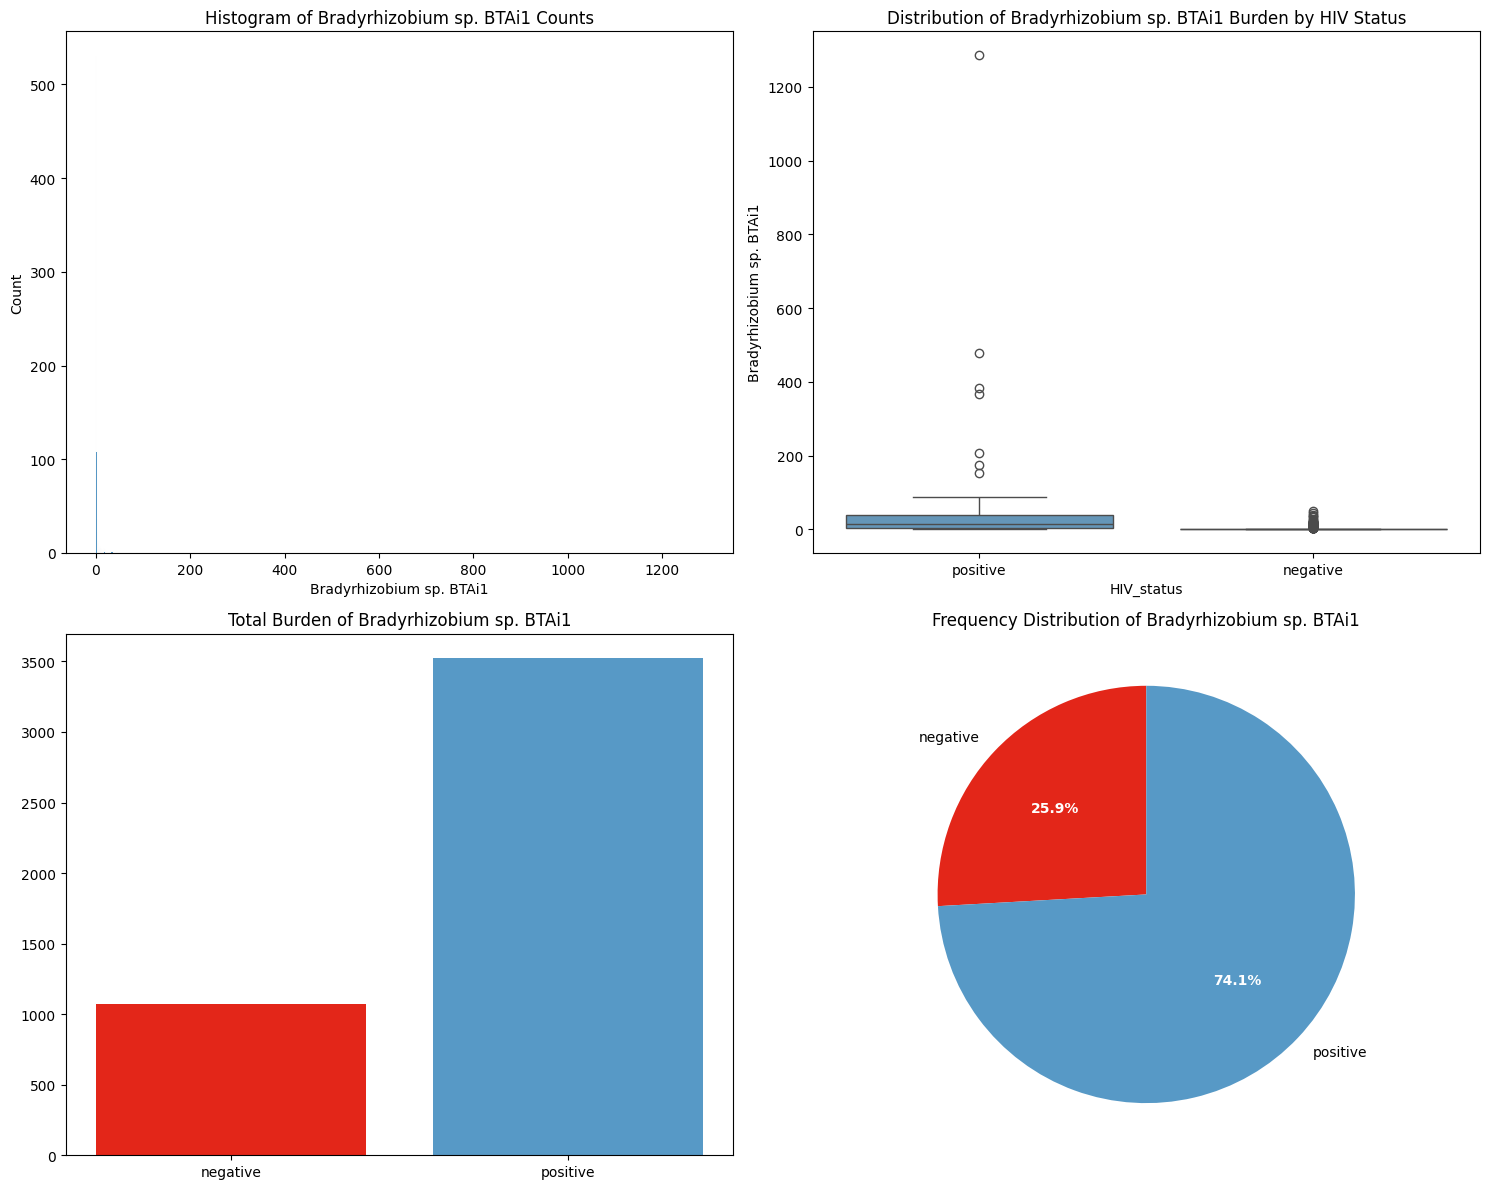

In [63]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Bradyrhizobium sp. BTAi1" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.2. _`Ralstonia insidiosa`_**

Frequency of Ralstonia insidiosa by HIV Status: HIV_status
negative    0.059603
positive    0.461538
dtype: float64
Detailed Statistics for Ralstonia insidiosa : count    794.000000
mean       1.030227
std        8.661730
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      150.000000
mode       0.000000
Name: Ralstonia insidiosa, dtype: float64
Total Burden of Ralstonia insidiosa in HIV Positive Samples: 626
Average Burden per HIV Positive Sample: 16.05128205128205
Total Burden of Ralstonia insidiosa in HIV Negative Samples: 192
Average Burden per HIV Negative Sample: 0.2543046357615894
Number of samples with Ralstonia insidiosa in HIV Positive group: 18
Number of samples with Ralstonia insidiosa in HIV Negative group: 45


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


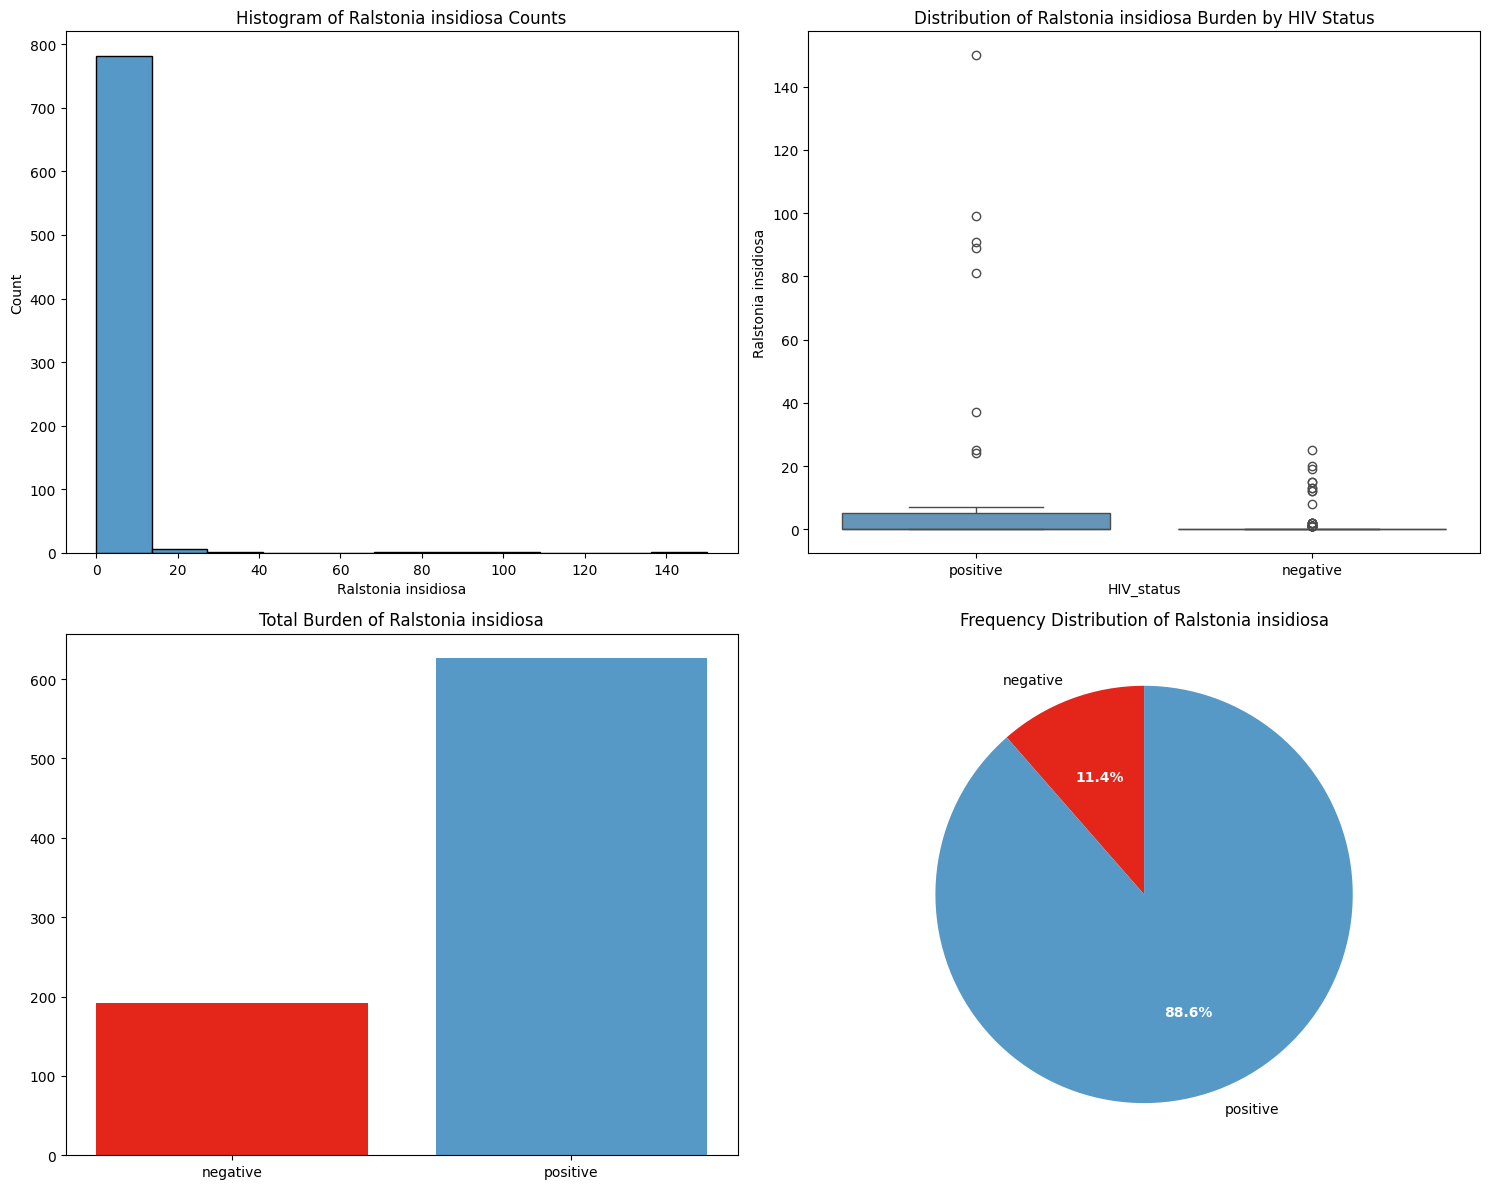

In [62]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Ralstonia insidiosa" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.3. _`Stenotrophomonas maltophilia`_**

Frequency of Stenotrophomonas maltophilia by HIV Status: HIV_status
negative    0.129801
positive    0.333333
dtype: float64
Detailed Statistics for Stenotrophomonas maltophilia : count    794.000000
mean       0.453401
std        3.544489
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       77.000000
mode       0.000000
Name: Stenotrophomonas maltophilia, dtype: float64
Total Burden of Stenotrophomonas maltophilia in HIV Positive Samples: 208
Average Burden per HIV Positive Sample: 5.333333333333333
Total Burden of Stenotrophomonas maltophilia in HIV Negative Samples: 152
Average Burden per HIV Negative Sample: 0.20132450331125828
Number of samples with Stenotrophomonas maltophilia in HIV Positive group: 13
Number of samples with Stenotrophomonas maltophilia in HIV Negative group: 98


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


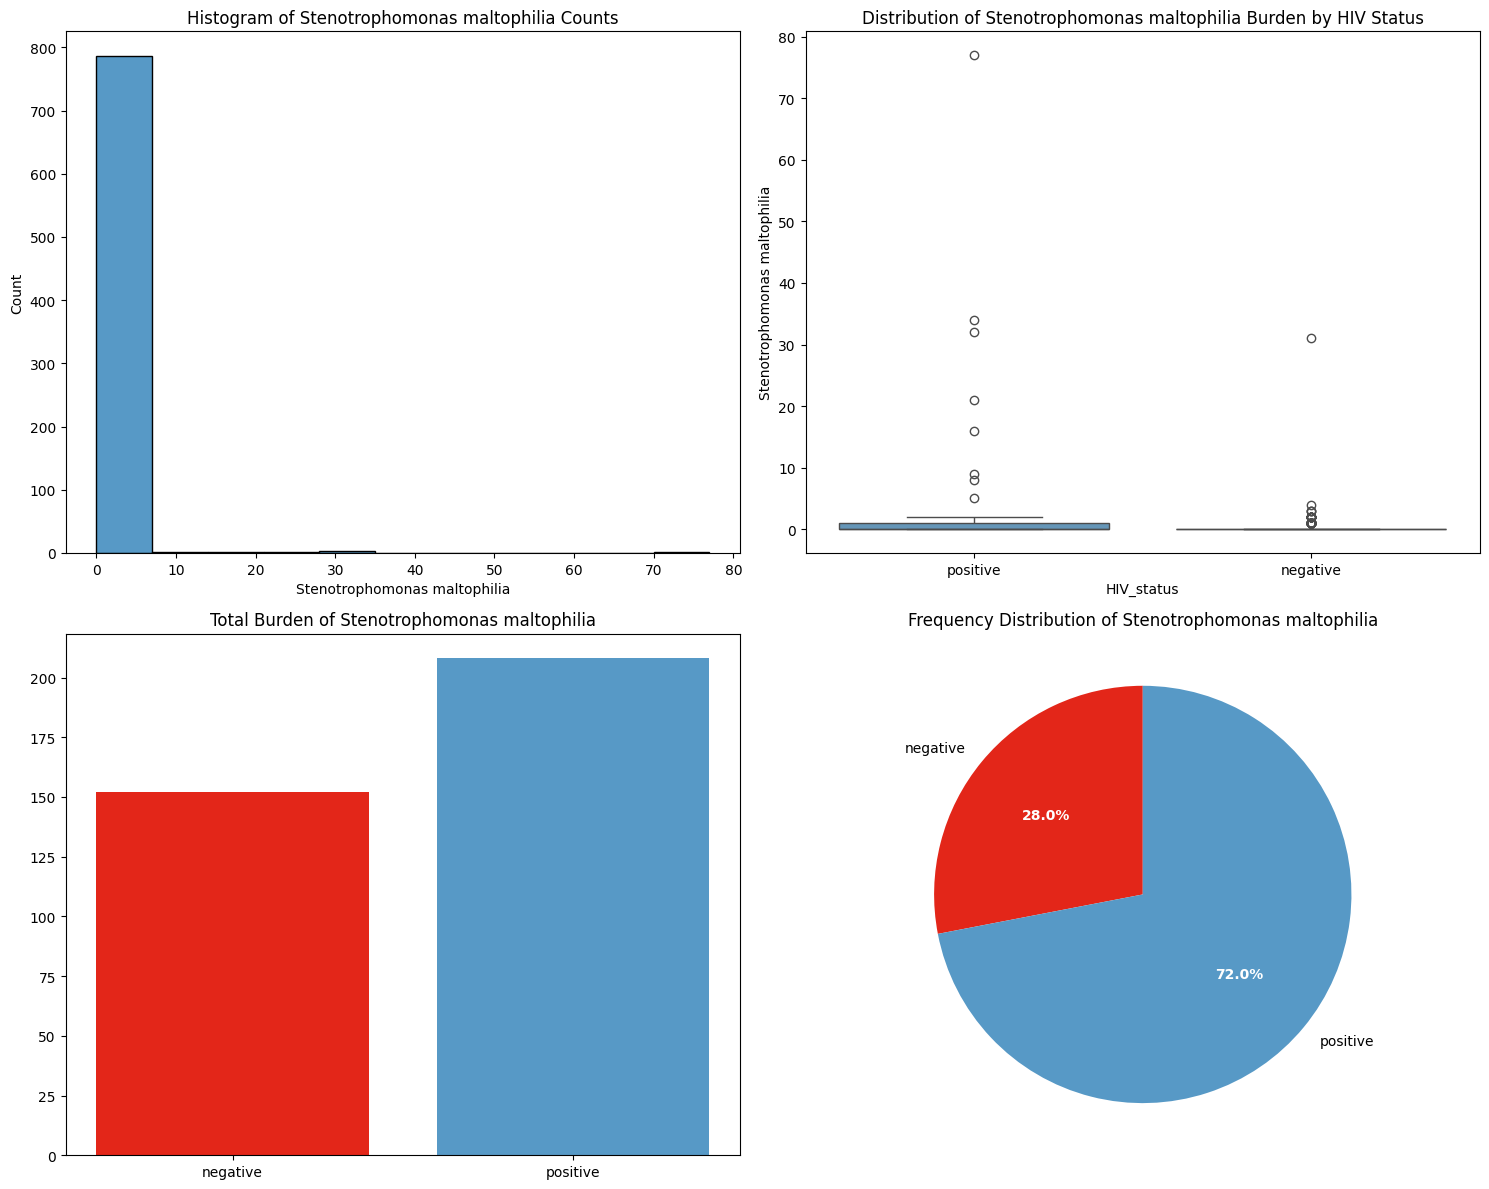

In [64]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Stenotrophomonas maltophilia" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.4. _`Herbaspirillum huttiense`_**

Frequency of Herbaspirillum huttiense by HIV Status: HIV_status
negative    0.196026
positive    0.538462
dtype: float64
Detailed Statistics for Herbaspirillum huttiense : count    794.000000
mean       0.329975
std        0.757931
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
mode       0.000000
Name: Herbaspirillum huttiense, dtype: float64
Total Burden of Herbaspirillum huttiense in HIV Positive Samples: 44
Average Burden per HIV Positive Sample: 1.1282051282051282
Total Burden of Herbaspirillum huttiense in HIV Negative Samples: 218
Average Burden per HIV Negative Sample: 0.28874172185430463
Number of samples with Herbaspirillum huttiense in HIV Positive group: 21
Number of samples with Herbaspirillum huttiense in HIV Negative group: 148


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


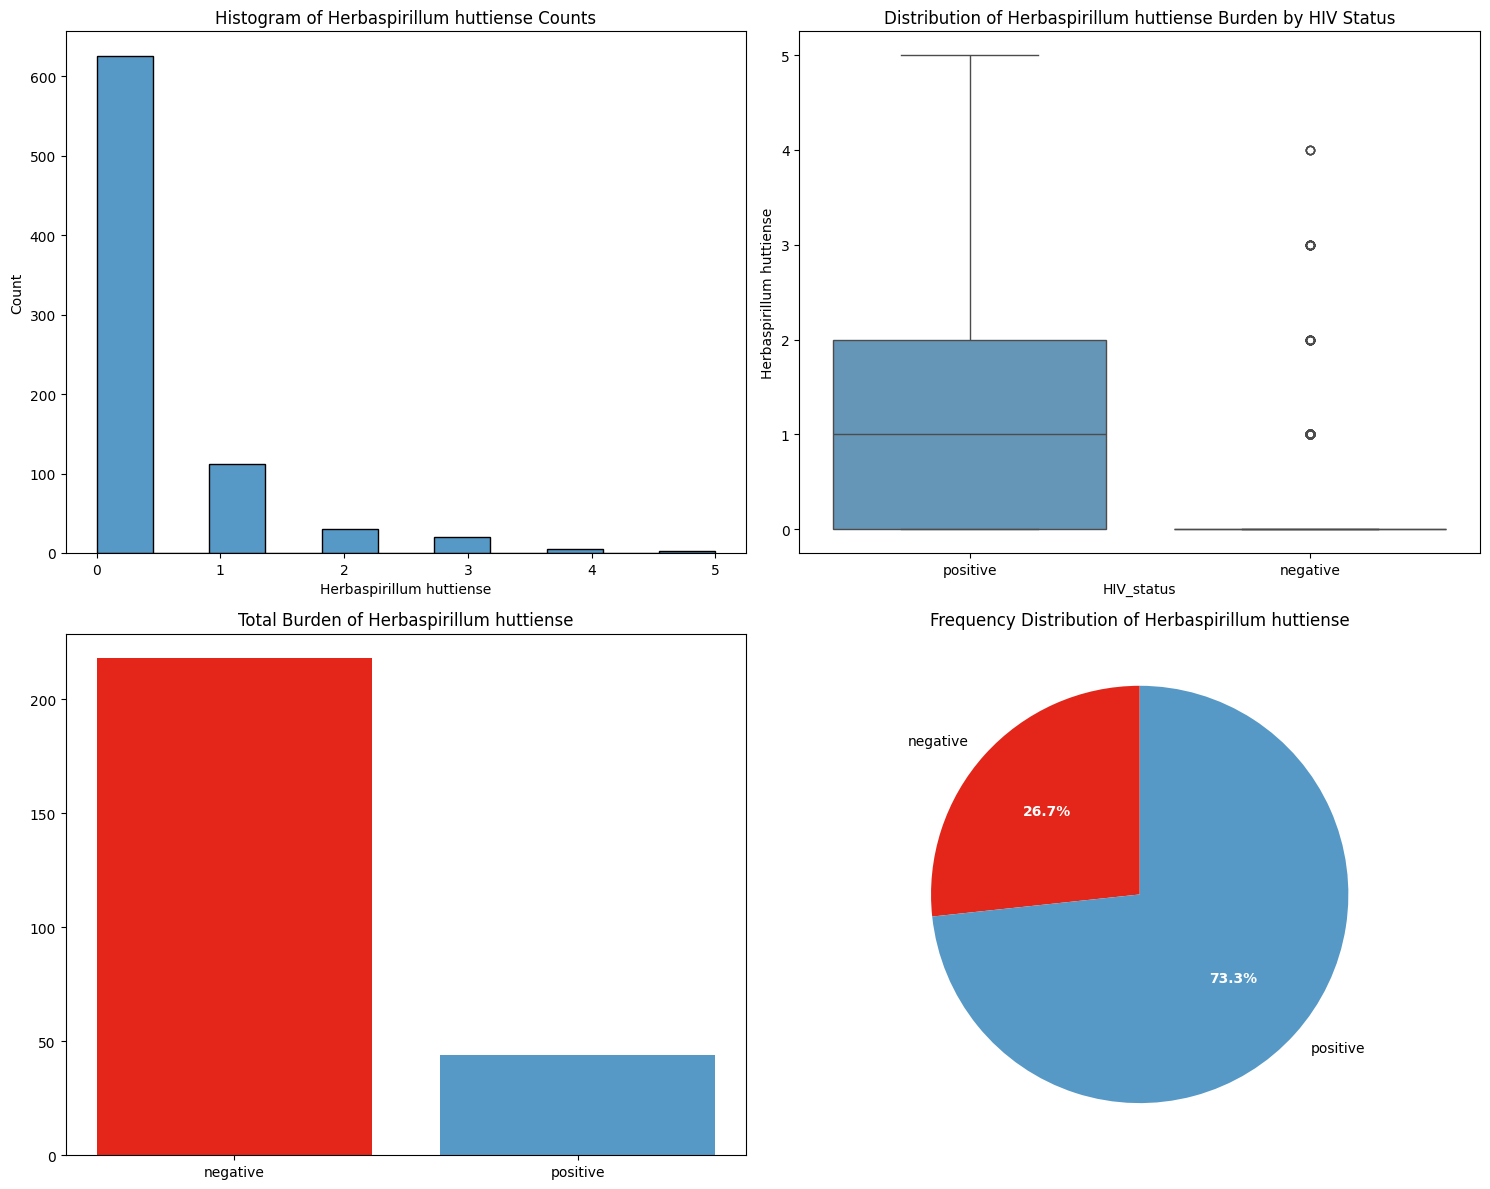

In [65]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Herbaspirillum huttiense" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.5. _`Ralstonia pickettii`_**

Frequency of Ralstonia pickettii by HIV Status: HIV_status
negative    0.033113
positive    0.333333
dtype: float64
Detailed Statistics for Ralstonia pickettii : count    794.000000
mean       1.491184
std       14.402012
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      284.000000
mode       0.000000
Name: Ralstonia pickettii, dtype: float64
Total Burden of Ralstonia pickettii in HIV Positive Samples: 29
Average Burden per HIV Positive Sample: 0.7435897435897436
Total Burden of Ralstonia pickettii in HIV Negative Samples: 1155
Average Burden per HIV Negative Sample: 1.5298013245033113
Number of samples with Ralstonia pickettii in HIV Positive group: 13
Number of samples with Ralstonia pickettii in HIV Negative group: 25


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


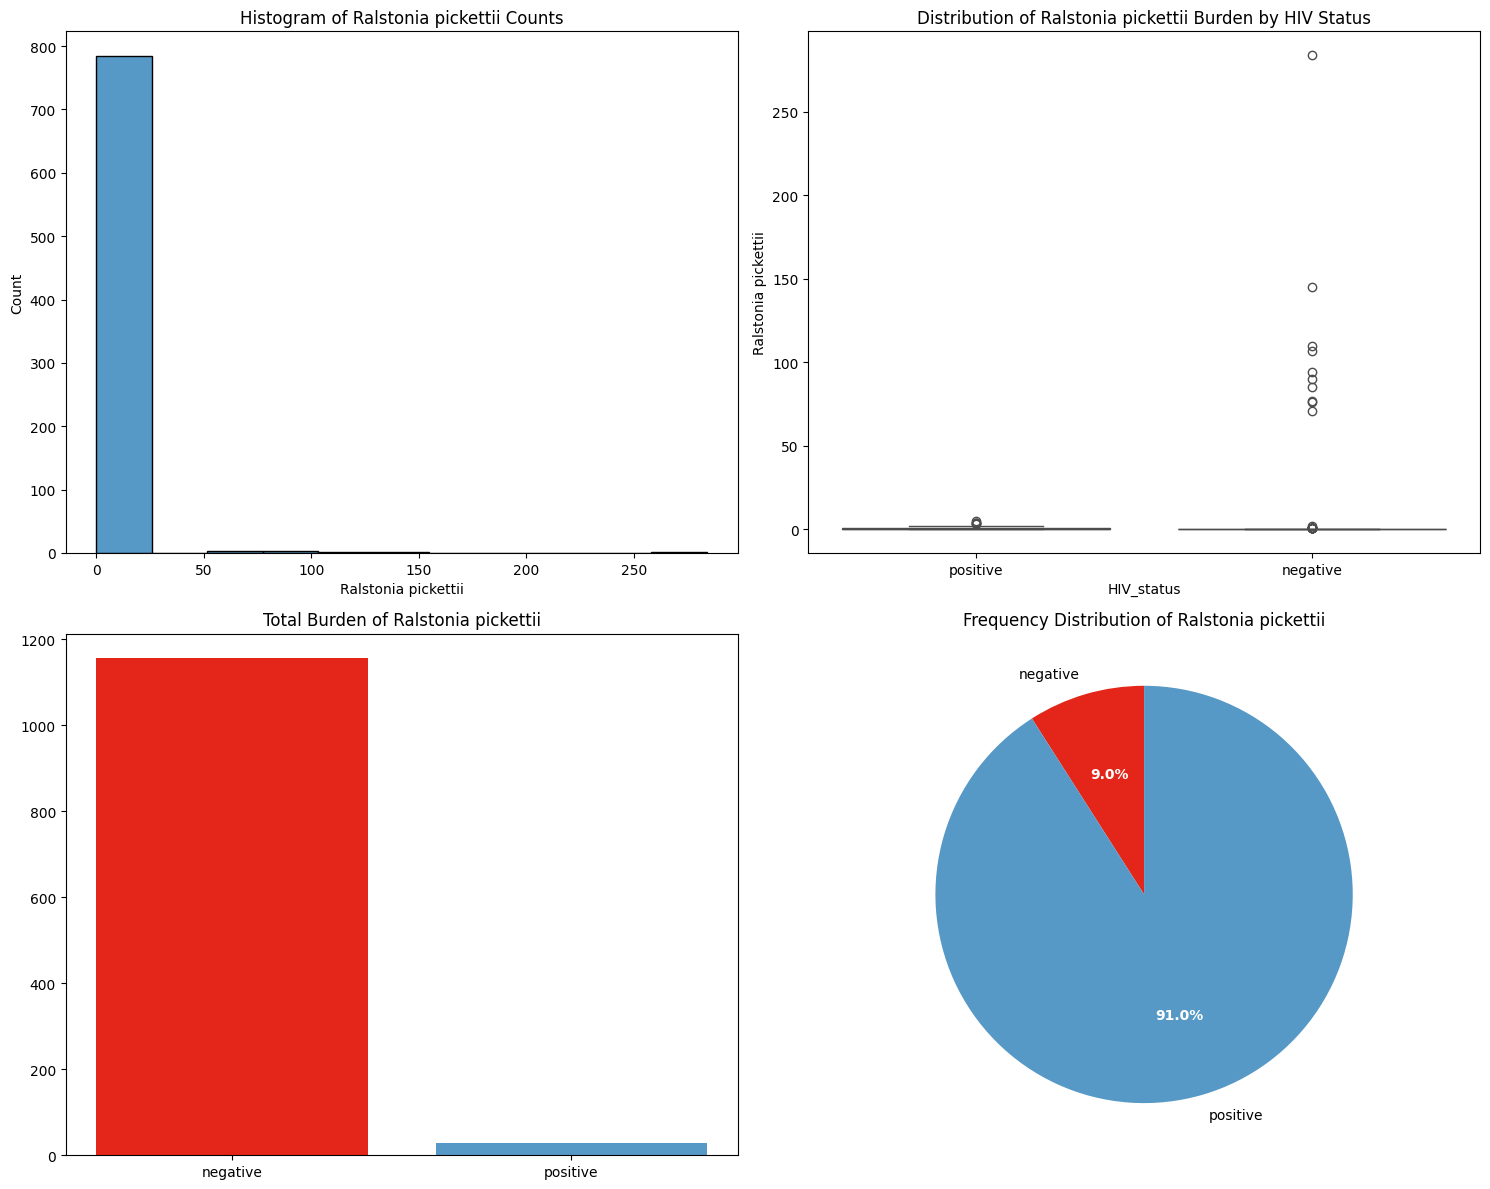

In [66]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Ralstonia pickettii" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.6. _`Microbacterium sp. Y-01`_**

Frequency of Microbacterium sp. Y-01 by HIV Status: HIV_status
negative    0.205298
positive    0.410256
dtype: float64
Detailed Statistics for Microbacterium sp. Y-01 : count    794.000000
mean       0.532746
std        3.807083
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       99.000000
mode       0.000000
Name: Microbacterium sp. Y-01, dtype: float64
Total Burden of Microbacterium sp. Y-01 in HIV Positive Samples: 112
Average Burden per HIV Positive Sample: 2.871794871794872
Total Burden of Microbacterium sp. Y-01 in HIV Negative Samples: 311
Average Burden per HIV Negative Sample: 0.4119205298013245
Number of samples with Microbacterium sp. Y-01 in HIV Positive group: 16
Number of samples with Microbacterium sp. Y-01 in HIV Negative group: 155


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


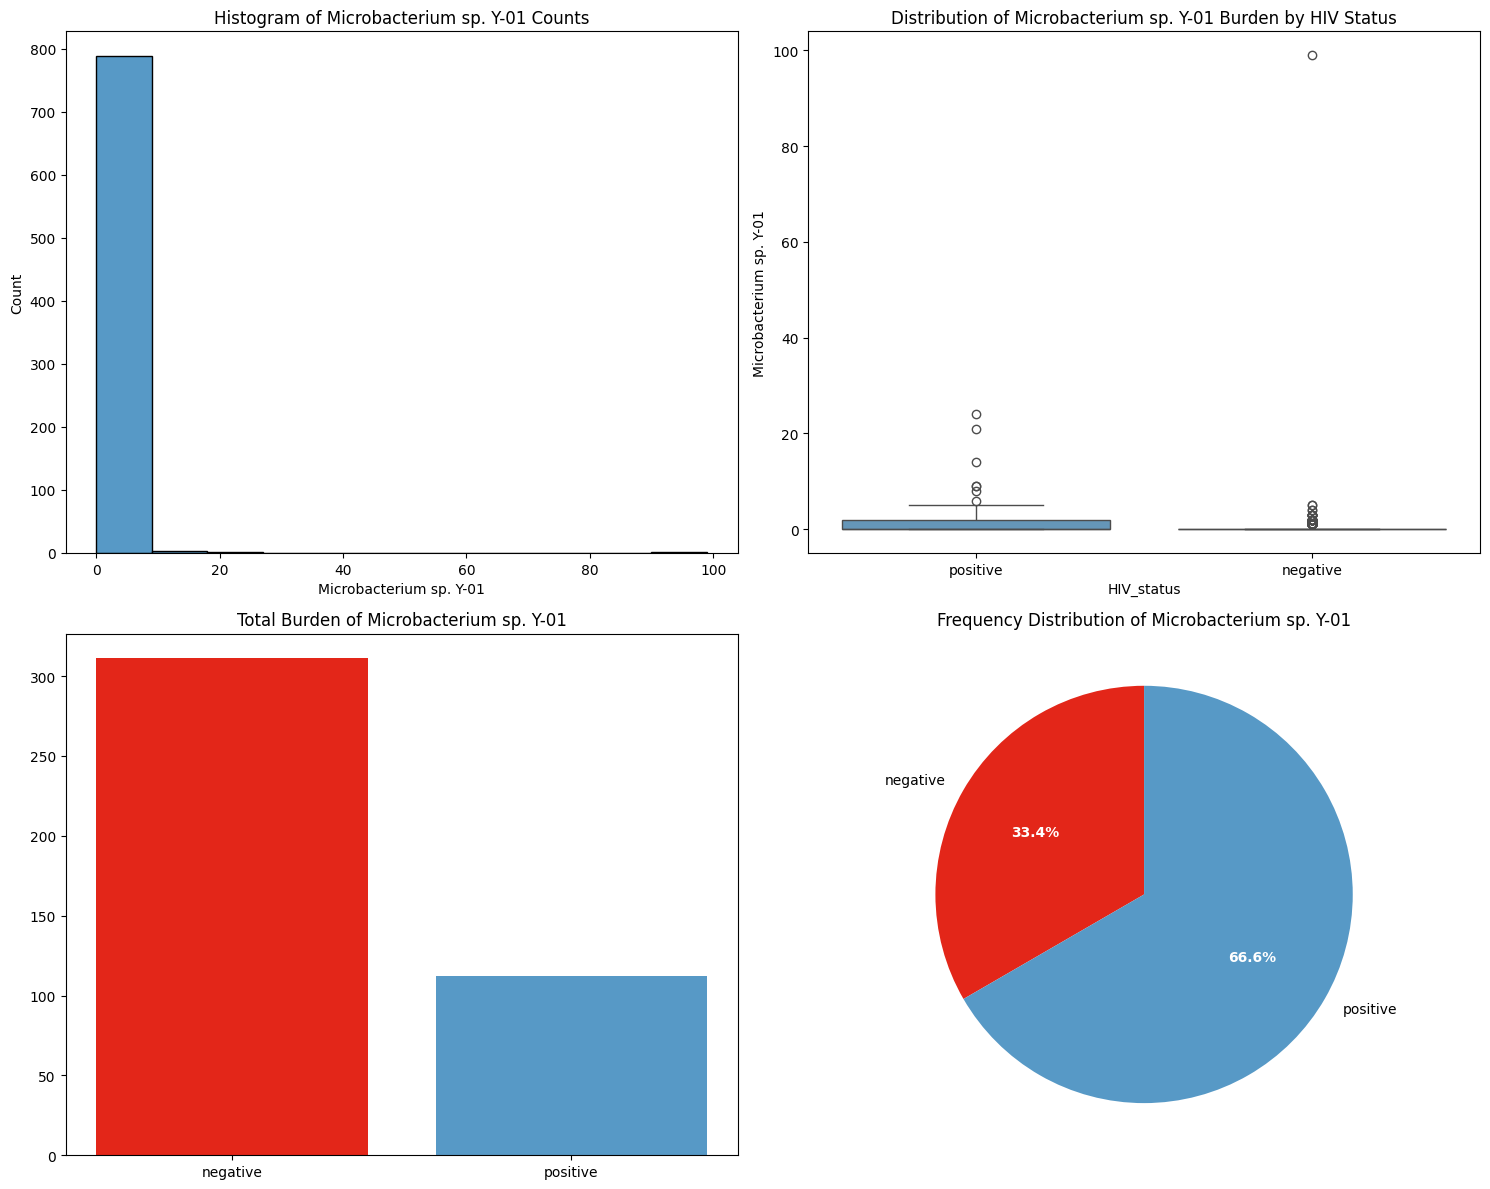

In [67]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Microbacterium sp. Y-01" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.7. _`Hydrogenophilus thermoluteolus`_**

Frequency of Hydrogenophilus thermoluteolus by HIV Status: HIV_status
negative    0.723179
positive    0.230769
dtype: float64
Detailed Statistics for Hydrogenophilus thermoluteolus : count    794.000000
mean       3.675063
std       15.871575
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max      416.000000
mode       0.000000
Name: Hydrogenophilus thermoluteolus, dtype: float64
Total Burden of Hydrogenophilus thermoluteolus in HIV Positive Samples: 13
Average Burden per HIV Positive Sample: 0.3333333333333333
Total Burden of Hydrogenophilus thermoluteolus in HIV Negative Samples: 2905
Average Burden per HIV Negative Sample: 3.847682119205298
Number of samples with Hydrogenophilus thermoluteolus in HIV Positive group: 9
Number of samples with Hydrogenophilus thermoluteolus in HIV Negative group: 546


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


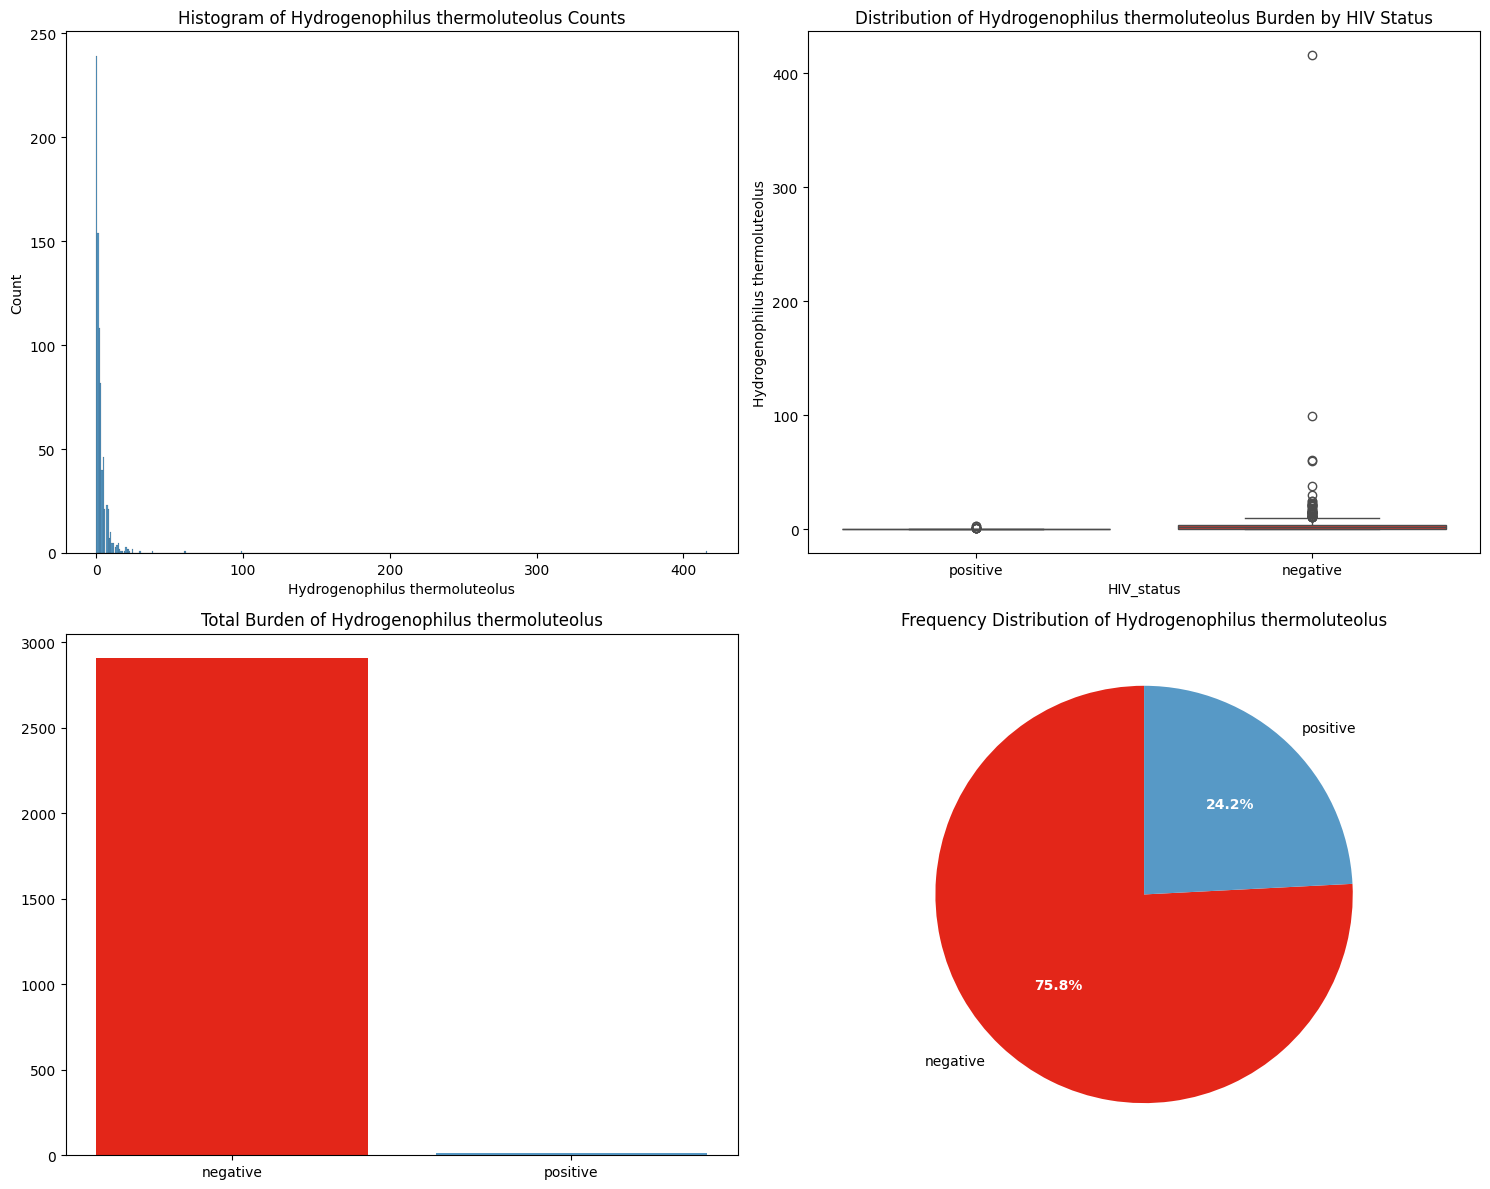

In [68]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Hydrogenophilus thermoluteolus" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.8. _`Moraxella osloensis`_**

Frequency of Moraxella osloensis by HIV Status: HIV_status
negative    0.875497
positive    0.564103
dtype: float64
Detailed Statistics for Moraxella osloensis : count    794.000000
mean       6.537783
std        8.412547
min        0.000000
25%        1.000000
50%        4.000000
75%        9.000000
max       97.000000
mode       1.000000
Name: Moraxella osloensis, dtype: float64
Total Burden of Moraxella osloensis in HIV Positive Samples: 70
Average Burden per HIV Positive Sample: 1.794871794871795
Total Burden of Moraxella osloensis in HIV Negative Samples: 5121
Average Burden per HIV Negative Sample: 6.782781456953642
Number of samples with Moraxella osloensis in HIV Positive group: 22
Number of samples with Moraxella osloensis in HIV Negative group: 661


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


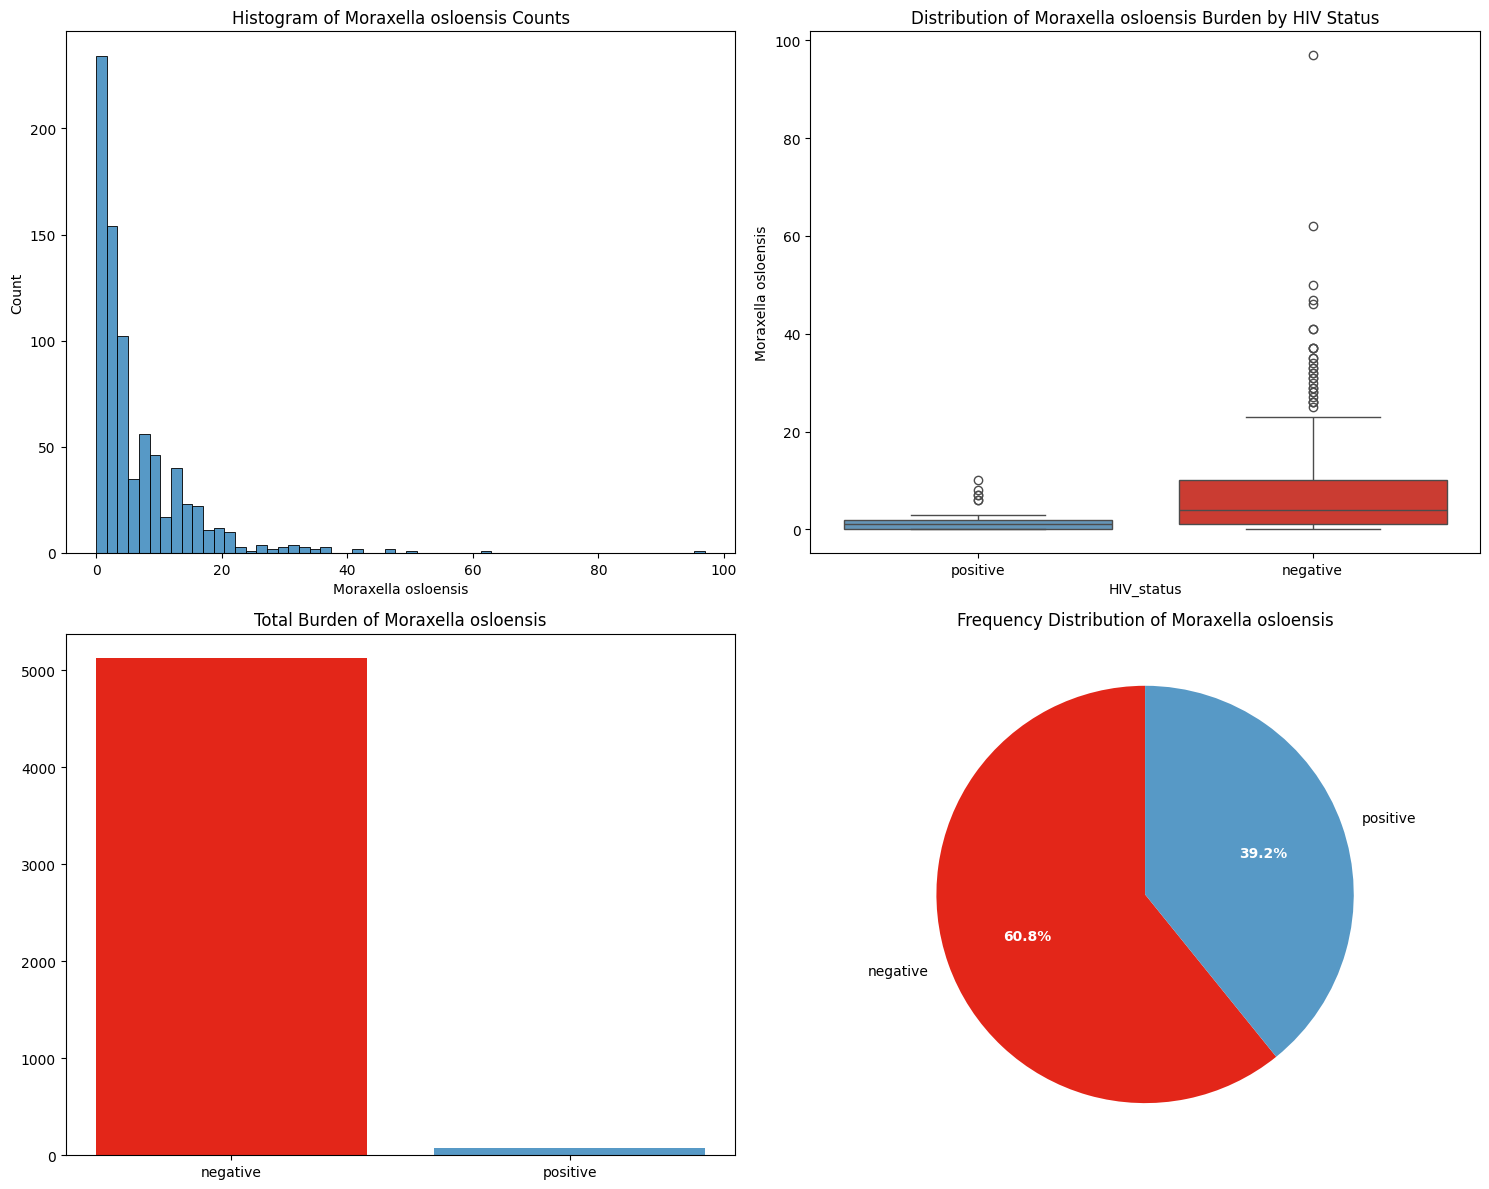

In [69]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Moraxella osloensis" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.9. _`Epilithonimonas vandammei`_**

Frequency of Epilithonimonas vandammei by HIV Status: HIV_status
negative    0.585430
positive    0.102564
dtype: float64
Detailed Statistics for Epilithonimonas vandammei : count    794.000000
mean       1.850126
std        4.079161
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       80.000000
mode       0.000000
Name: Epilithonimonas vandammei, dtype: float64
Total Burden of Epilithonimonas vandammei in HIV Positive Samples: 4
Average Burden per HIV Positive Sample: 0.10256410256410256
Total Burden of Epilithonimonas vandammei in HIV Negative Samples: 1465
Average Burden per HIV Negative Sample: 1.9403973509933774
Number of samples with Epilithonimonas vandammei in HIV Positive group: 4
Number of samples with Epilithonimonas vandammei in HIV Negative group: 442


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


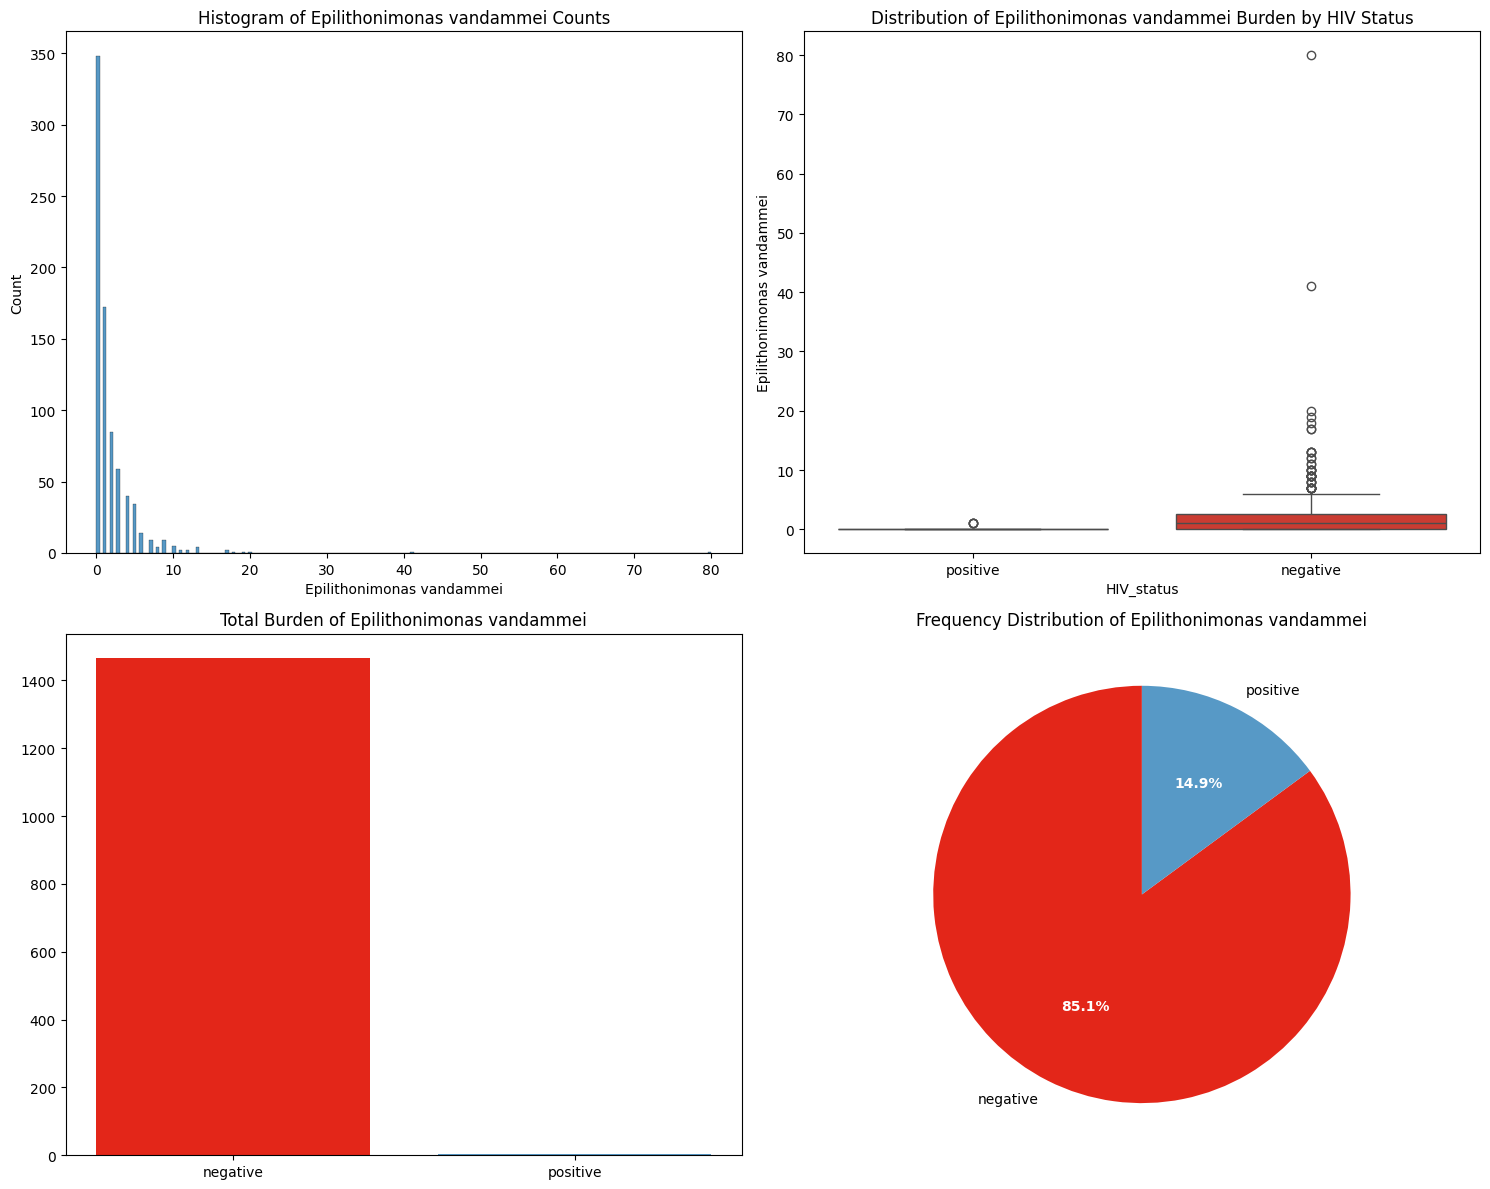

In [70]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Epilithonimonas vandammei" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.11. _`Acinetobacter johnsonii`_**

Frequency of Acinetobacter johnsonii by HIV Status: HIV_status
negative    0.680795
positive    0.282051
dtype: float64
Detailed Statistics for Acinetobacter johnsonii : count    794.000000
mean       9.659950
std       19.999565
min        0.000000
25%        0.000000
50%        2.000000
75%       10.000000
max      186.000000
mode       0.000000
Name: Acinetobacter johnsonii, dtype: float64
Total Burden of Acinetobacter johnsonii in HIV Positive Samples: 49
Average Burden per HIV Positive Sample: 1.2564102564102564
Total Burden of Acinetobacter johnsonii in HIV Negative Samples: 7621
Average Burden per HIV Negative Sample: 10.094039735099338
Number of samples with Acinetobacter johnsonii in HIV Positive group: 11
Number of samples with Acinetobacter johnsonii in HIV Negative group: 514


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


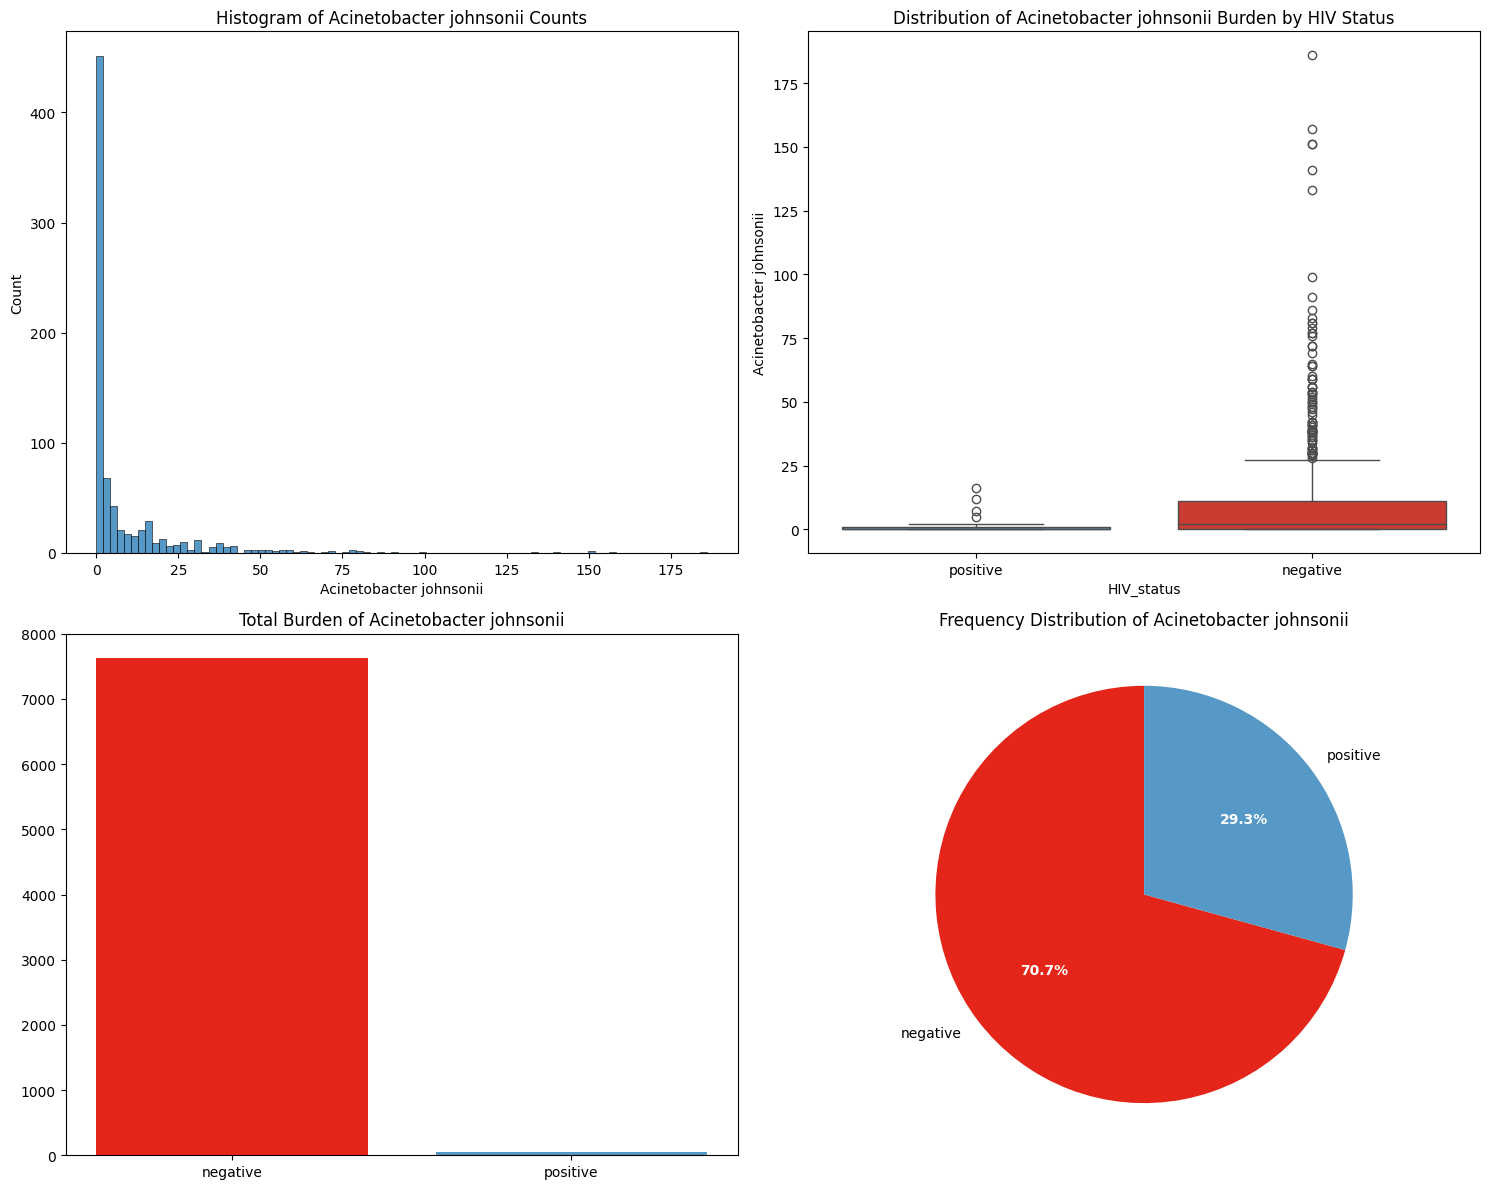

In [71]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Acinetobacter johnsonii" counts/counts_species_filtered.csv metadata.csv

#### **Part 3.6.12. _`Chryseobacterium manosquense`_**

Frequency of Chryseobacterium manosquense by HIV Status: HIV_status
negative    0.645033
positive    0.205128
dtype: float64
Detailed Statistics for Chryseobacterium manosquense : count    794.000000
mean       2.400504
std        3.777320
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       53.000000
mode       0.000000
Name: Chryseobacterium manosquense, dtype: float64
Total Burden of Chryseobacterium manosquense in HIV Positive Samples: 17
Average Burden per HIV Positive Sample: 0.4358974358974359
Total Burden of Chryseobacterium manosquense in HIV Negative Samples: 1889
Average Burden per HIV Negative Sample: 2.5019867549668873
Number of samples with Chryseobacterium manosquense in HIV Positive group: 8
Number of samples with Chryseobacterium manosquense in HIV Negative group: 487


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


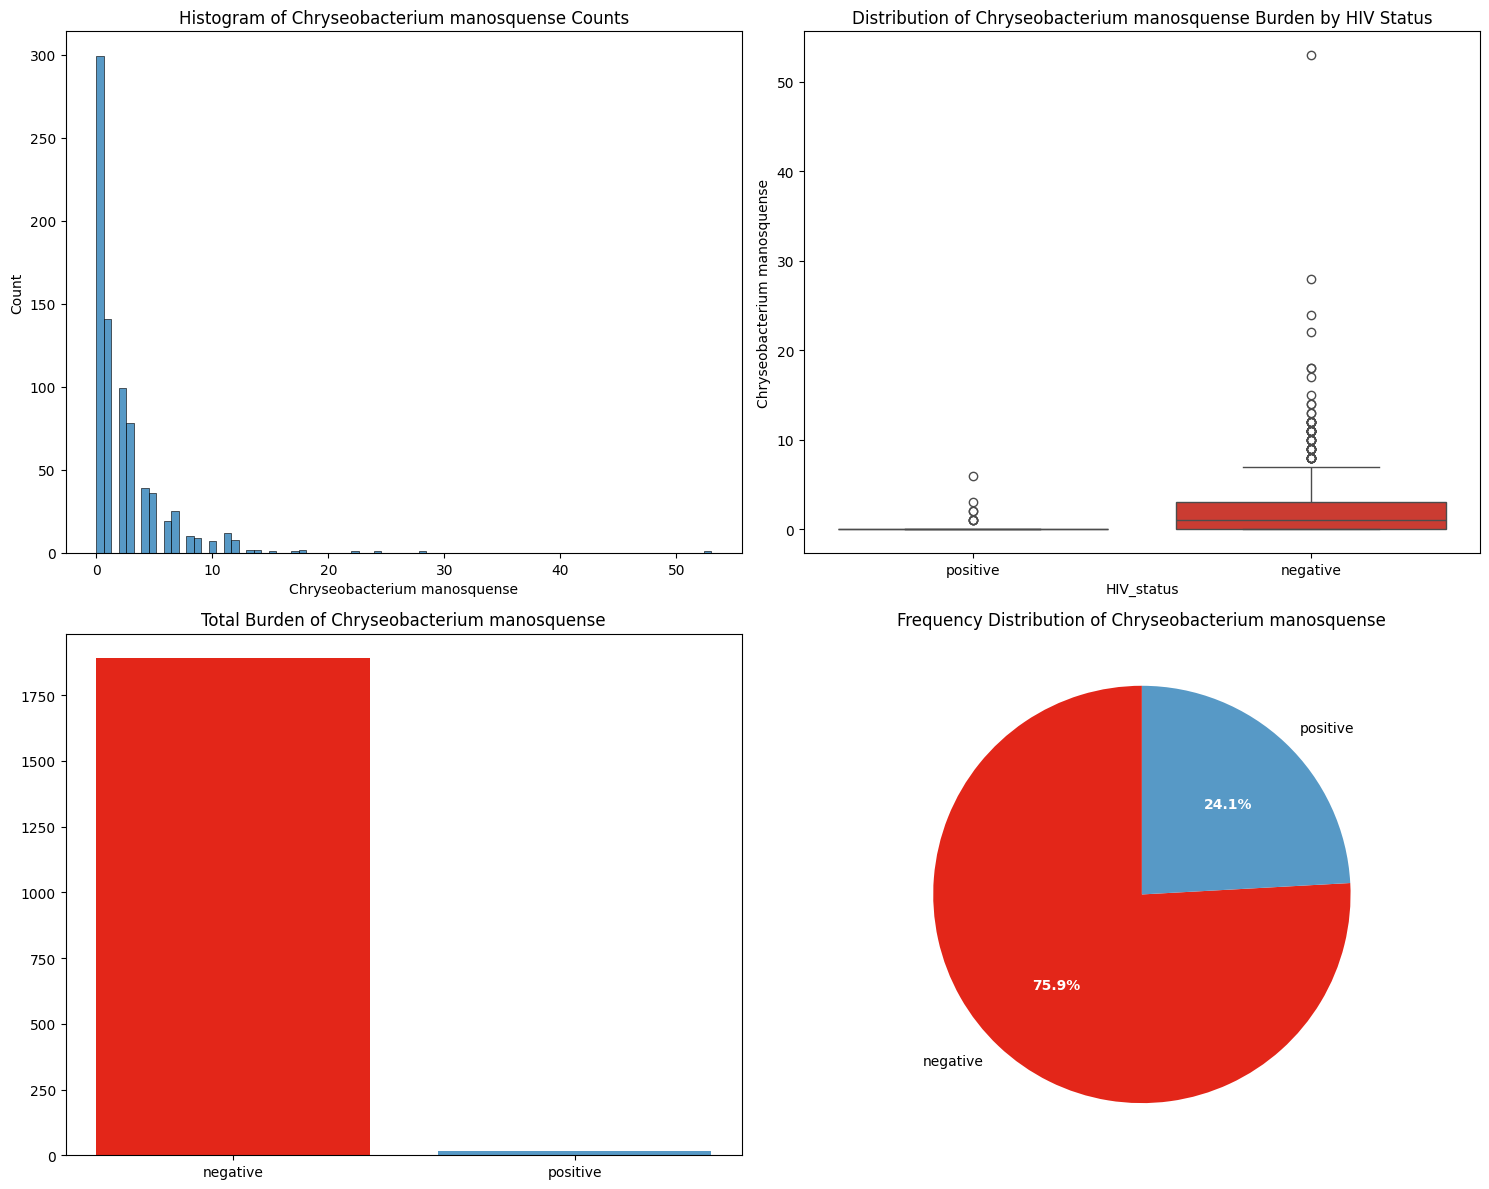

In [72]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Chryseobacterium manosquense" counts/counts_species_filtered.csv metadata.csv

## **Part 4. Bar-plot - Relative Abundance**

In [ ]:
! mkdir Bar_plots

In [73]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts_species} {path_to_counts_genus} {path_to_counts_family} {path_to_counts_order} {path_to_counts_class} {path_to_counts_phylum}
! Rscript scripts/Bar_plot.R metadata.csv counts/counts_species_filtered.csv counts/counts_genus.csv counts/counts_family.csv counts/counts_class.csv counts/counts_order.csv counts/counts_phylum.csv 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Предупреждения:
1: пакет 'dplyr' был собран под R версии 4.3.3 
2: пакет 'stringr' был собран под R версии 4.3.3 
3: пакет 'forcats' был собран под R версии 4.3.3 
Предупреждение:
пакет 'paletteer' был собран под R версии 4.3.3 

Присоединяю пакет: 'data.table'

Следующие объекты скрыты от 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

Следующие объекты скрыты от 'package:dplyr':

    between, first, last

Следую

![alt text](Bar_plots/combined.png)

## **Part 5. Core microbiome**

### **Part 5.1. HIV positive**

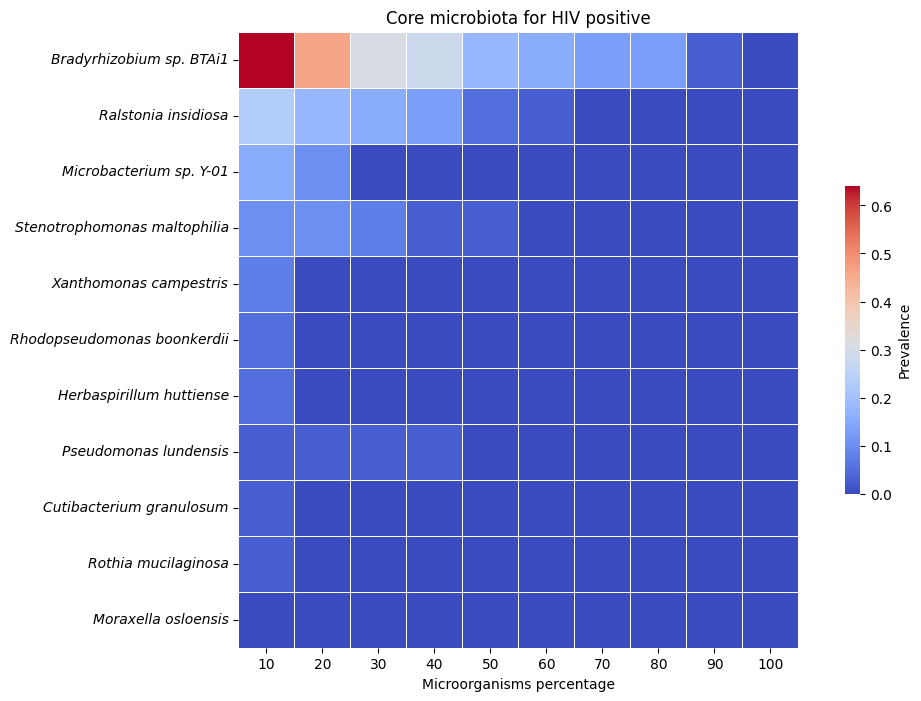

In [8]:
%run scripts/core_microbiota_HIV.py counts/counts_species_filtered.csv metadata.csv positive 0.01

### **Part 5.1. HIV negative**

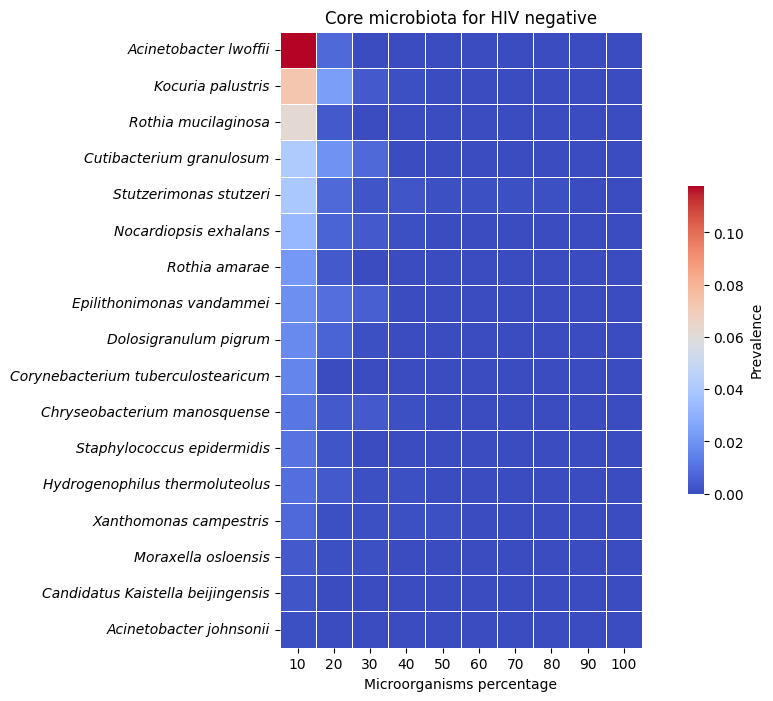

In [7]:
%run scripts/core_microbiota_HIV.py counts/counts_species_filtered.csv metadata.csv negative 0.01

## **Part 6. Results validation - Randomizer**

In [74]:
# Usage
# {path_to_script} {n_samples_to_randomize} {n_iterations} {path_to_metadata} {path_to_counts}
%run scripts/randomizer.py 39 20 metadata.csv counts/counts_species_filtered.csv

Leishmania mexicana            0.523782
Babesia bigemina               0.406244
Toxoplasma gondii              0.744392
Geothrix oryzae                0.744392
Parachlamydia acanthamoebae    0.744392
                                 ...   
Haloquadratum walsbyi          0.688188
Natronorubrum daqingense       0.536784
Halalkalicoccus jeotgali       0.379271
Halococcus qingdaonensis       0.508566
Halococcus dombrowskii         0.487163
Length: 2053, dtype: float64


# **CHAPTER 3. VIRUSES ONLY (`IonTorrent` only)**

## **Part 1. Getting `counts.csv` files**

### **Part 1.1. Parse `ALL/VIRUSES.txt` file to counts files on several taxonomic levels**

In [6]:
! mkdir counts_viruses

#### **Part 1.1.1. _`Species`_ level**

In [75]:
%%bash

grep -E "s__" ALL/VIRUSES.txt \
| grep -v "t__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_species.txt

#### **Part 1.1.2. _`Genus`_ level**

In [76]:
%%bash

grep -E "g__" ALL/VIRUSES.txt \
| grep -v "t__" \
| grep -v "s__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_genus.txt

#### **Part 1.1.3. _`Family`_ level**

In [77]:
%%bash

grep -E "f__" ALL/VIRUSES.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_family.txt

#### **Part 1.1.4. _`Order`_ level**

In [78]:
%%bash

grep -E "o__" ALL/VIRUSES.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_order.txt

#### **Part 1.1.5. _`Class`_ level**

In [79]:
%%bash

grep -E "c__" ALL/VIRUSES.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| grep -v "o__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_class.txt

#### **Part 1.1.6. _`Phylum`_ level**

In [80]:
%%bash

grep -E "p__" ALL/VIRUSES.txt \
| grep -v "t__" \
| grep -v "s__" \
| grep -v "g__" \
| grep -v "f__" \
| grep -v "o__" \
| grep -v "c__" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_viruses/counts_phylum.txt

### **Part 1.2. Process counts files**

In [81]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_species.txt

In [82]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_genus.txt

In [83]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_family.txt

In [84]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_order.txt

In [85]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_class.txt

In [86]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL/COMBINED.txt counts_viruses/counts_phylum.txt

### **Part 1.3. Convert to `csv` file format**

In [87]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_species.txt

Data has been successfully converted and saved as 'counts_viruses/counts_species.csv'.


In [88]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_genus.txt

Data has been successfully converted and saved as 'counts_viruses/counts_genus.csv'.


In [89]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_family.txt

Data has been successfully converted and saved as 'counts_viruses/counts_family.csv'.


In [90]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_order.txt

Data has been successfully converted and saved as 'counts_viruses/counts_order.csv'.


In [91]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_class.txt

Data has been successfully converted and saved as 'counts_viruses/counts_class.csv'.


In [92]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_viruses/counts_phylum.txt

Data has been successfully converted and saved as 'counts_viruses/counts_phylum.csv'.


### **Part 1.4. Filter contaminants once more**

In [93]:
# Usage
# {path_to_script} {path_to_input_file} {path_to_output_file}
%run scripts/filter_possible_contaminants.py counts_viruses/counts_species.csv counts_viruses/counts_species_filtered.csv

## **Part 2. Descriptive statistics**

### **Part 2.1. _`Species`_ level**

count    794.000000
mean       0.289673
std        1.666136
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       37.000000
Name: total_counts, dtype: float64


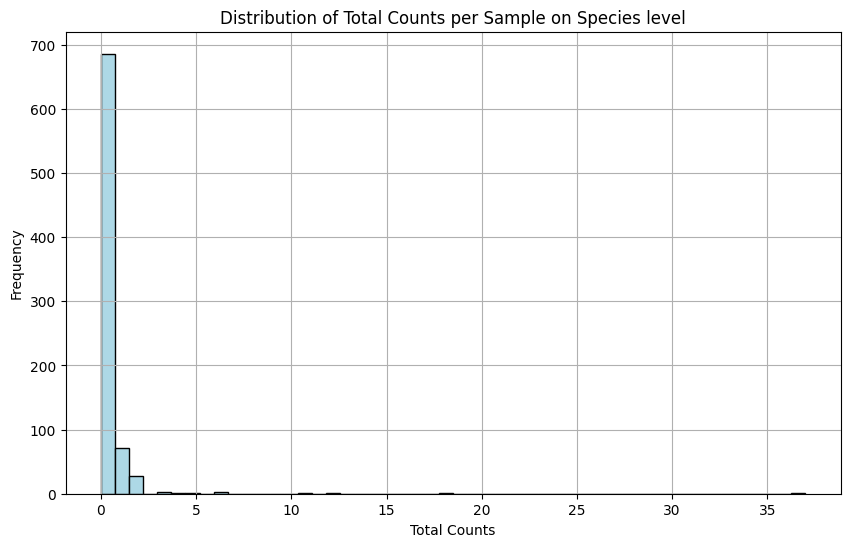

In [94]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_species_filtered.csv" Species

### **Part 2.2. _`Genus`_ level**

count    794.000000
mean       1.338791
std        4.555094
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       97.000000
Name: total_counts, dtype: float64


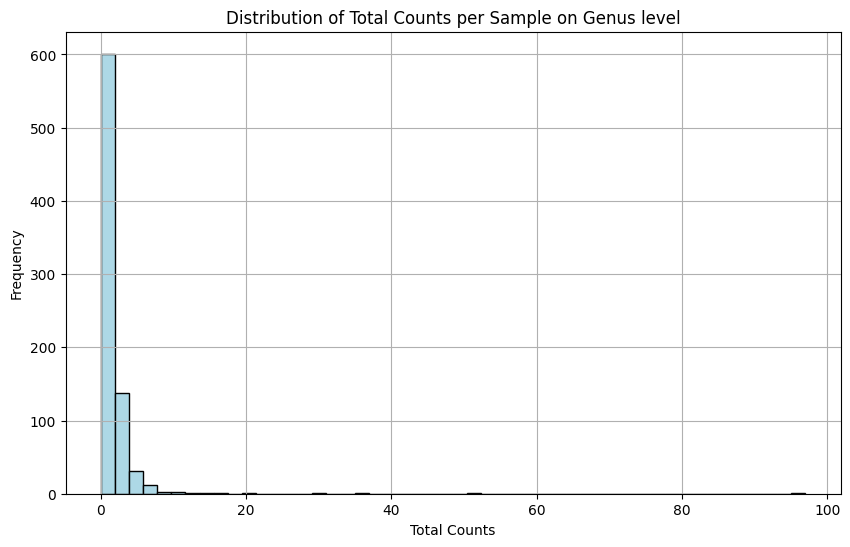

In [95]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_genus.csv" Genus

### **Part 2.3. _`Family`_ level**

count    794.000000
mean       0.833753
std        4.463959
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       97.000000
Name: total_counts, dtype: float64


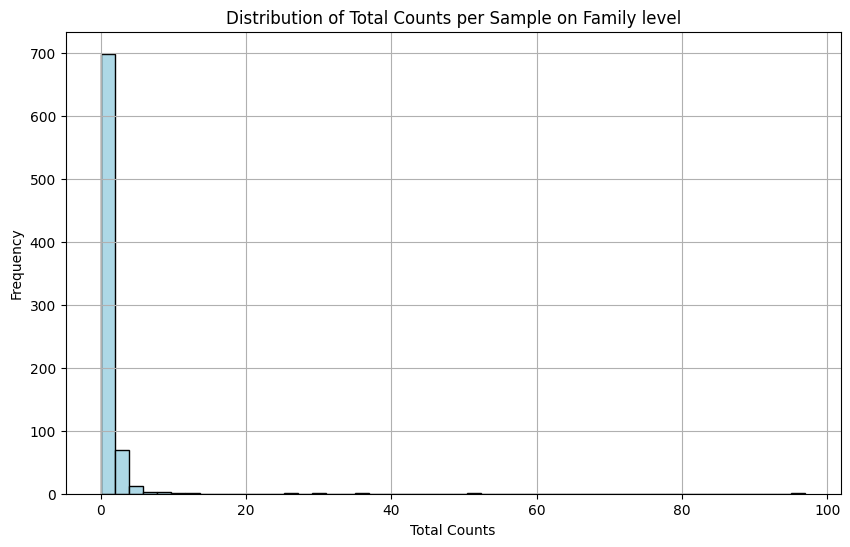

In [96]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_family.csv" Family

### **Part 2.4. _`Order`_ level**

count    794.000000
mean       0.502519
std        4.386511
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       97.000000
Name: total_counts, dtype: float64


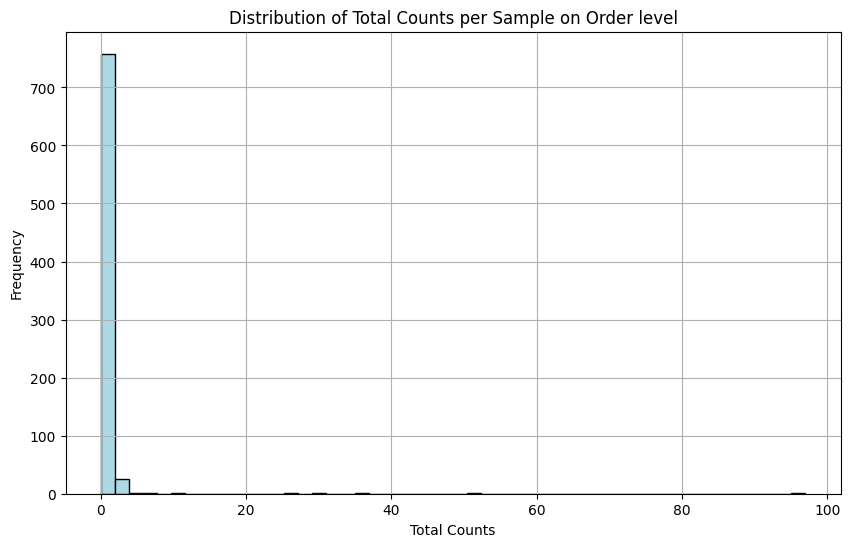

In [97]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_order.csv" Order

### **Part 2.5. _`Class`_ level**

count    794.000000
mean       1.701511
std        7.957030
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max      182.000000
Name: total_counts, dtype: float64


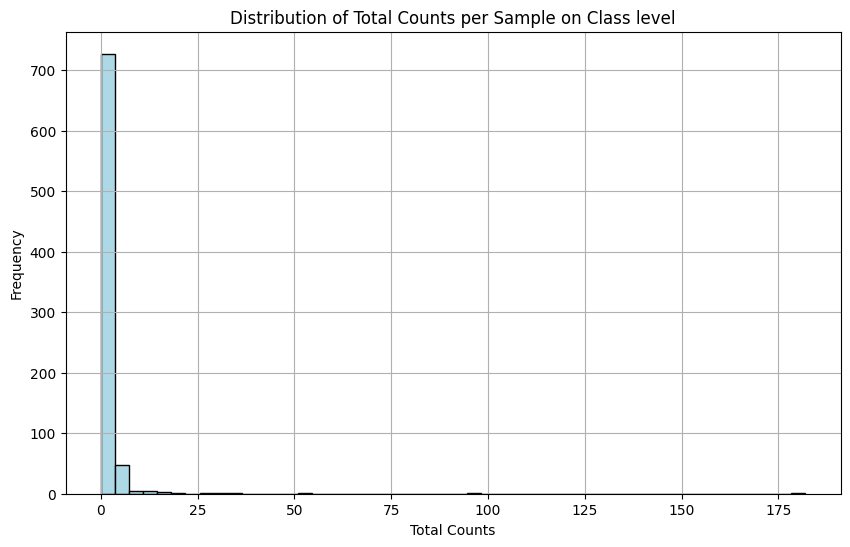

In [98]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_class.csv" Class

### **Part 2.6. _`Phylum`_ level**

count    794.000000
mean       1.701511
std        7.957030
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max      182.000000
Name: total_counts, dtype: float64


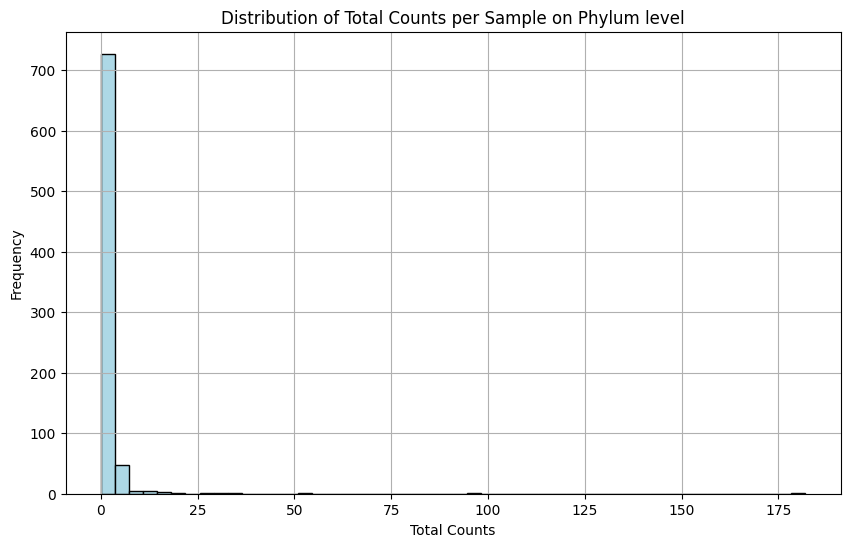

In [99]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_viruses/counts_phylum.csv" Phylum

## **Part 3. Comparative statistics**

### **Part 3.1. Differential Abundance**

#### **Part 3.1.1. _`Species`_ level**

In [100]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_species_filtered.csv MaAsLin2_results/viruses/species

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/species/maaslin2.log"
2024-05-08 13:05:43.078845 INFO::Writing function arguments to log file
2024-05-08 13:05:43.144746 INFO::Verifying options selected are valid
2024-05-08 13:05:43.218526 INFO::Determining format of input files
2024-05-08 13:05:43.221546 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:05:43.228322 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:05:43.232027 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:05:43.234522 INFO::Total samples in data: 794
2024-05-08 13:05:43.236934 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:05:43.240751 INFO::Total filtered features: 0
2024-05-08 13:05:43.243351 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:05:43.248048 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:05:43.

In [108]:
MaAsLin2_results_viruses_species = pd.read_csv('MaAsLin2_results/viruses/species/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_species

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Cytomegalovirus.humanbeta5,HIV_status,positive,0.236173,0.089506,794,15,0.008488,0.110341


#### **Part 3.1.2. _`Genus`_ level**

In [101]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_genus.csv MaAsLin2_results/viruses/genus

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/genus/maaslin2.log"
2024-05-08 13:05:53.727725 INFO::Writing function arguments to log file
2024-05-08 13:05:53.776374 INFO::Verifying options selected are valid
2024-05-08 13:05:53.823427 INFO::Determining format of input files
2024-05-08 13:05:53.826508 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:05:53.834583 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:05:53.838942 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:05:53.841648 INFO::Total samples in data: 794
2024-05-08 13:05:53.844306 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:05:53.849574 INFO::Total filtered features: 0
2024-05-08 13:05:53.852398 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:05:53.860854 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:05:53.86

In [102]:
MaAsLin2_results_viruses_genus = pd.read_csv('MaAsLin2_results/viruses/genus/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_genus

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Orthohepadnavirus,HIV_status,positive,0.025641,0.005760,794,1,0.000010,0.000477
1,Friunavirus,HIV_status,positive,0.075599,0.018237,794,2,0.000038,0.000921
2,Cytomegalovirus,HIV_status,positive,0.318904,0.107737,794,15,0.003168,0.051742
3,Mupapillomavirus,HIV_status,positive,0.060983,0.023694,794,3,0.010242,0.121119
4,Ghunavirus,HIV_status,positive,-0.488455,0.199748,794,129,0.014688,0.121119
5,Skunavirus,HIV_status,positive,0.289005,0.118356,794,36,0.014831,0.121119


#### **Part 3.1.3. _`Family`_ level**

In [103]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_family.csv MaAsLin2_results/viruses/family

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/family/maaslin2.log"
2024-05-08 13:06:11.511169 INFO::Writing function arguments to log file
2024-05-08 13:06:11.561006 INFO::Verifying options selected are valid
2024-05-08 13:06:11.608381 INFO::Determining format of input files
2024-05-08 13:06:11.611467 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:06:11.618586 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:06:11.622319 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:06:11.624865 INFO::Total samples in data: 794
2024-05-08 13:06:11.627382 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:06:11.631506 INFO::Total filtered features: 0
2024-05-08 13:06:11.634158 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:06:11.639475 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:06:11.6

In [104]:
MaAsLin2_results_viruses_family = pd.read_csv('MaAsLin2_results/viruses/family/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_family

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Hepadnaviridae,HIV_status,positive,0.025641,0.00576,794,1,0.00001,0.000195


#### **Part 3.1.4. _`Order`_ level**

In [105]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_order.csv MaAsLin2_results/viruses/order

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/order/maaslin2.log"
2024-05-08 13:06:23.579847 INFO::Writing function arguments to log file
2024-05-08 13:06:23.628298 INFO::Verifying options selected are valid
2024-05-08 13:06:23.679035 INFO::Determining format of input files
2024-05-08 13:06:23.682656 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:06:23.690451 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:06:23.694652 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:06:23.697441 INFO::Total samples in data: 794
2024-05-08 13:06:23.70018 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:06:23.704306 INFO::Total filtered features: 0
2024-05-08 13:06:23.707828 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:06:23.713593 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:06:23.716

In [106]:
MaAsLin2_results_viruses_order = pd.read_csv('MaAsLin2_results/viruses/order/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_order

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Blubervirales,HIV_status,positive,0.025641,0.00576,794,1,0.00001,0.000088


#### **Part 3.1.5. _`Class`_ level**

In [107]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_class.csv MaAsLin2_results/viruses/class

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/class/maaslin2.log"
2024-05-08 13:06:41.714213 INFO::Writing function arguments to log file
2024-05-08 13:06:41.763122 INFO::Verifying options selected are valid
2024-05-08 13:06:41.809549 INFO::Determining format of input files
2024-05-08 13:06:41.812484 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:06:41.819214 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:06:41.822807 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:06:41.825253 INFO::Total samples in data: 794
2024-05-08 13:06:41.827677 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:06:41.831284 INFO::Total filtered features: 0
2024-05-08 13:06:41.833911 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:06:41.838152 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:06:41.84

In [108]:
MaAsLin2_results_viruses_class = pd.read_csv('MaAsLin2_results/viruses/class/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_class

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Revtraviricetes,HIV_status,positive,0.024317,0.008196,794,2,0.003099,0.027895


#### **Part 3.1.6. _`Phylum`_ level**

In [109]:
# Usage
# {path_to_script} {path_to_metadata} {path_to_counts} {path_to_output}
! Rscript scripts/MaAsLin2.R metadata.csv counts_viruses/counts_phylum.csv MaAsLin2_results/viruses/phylum

[1] "Warning: Deleting existing log file: MaAsLin2_results/viruses/phylum/maaslin2.log"
2024-05-08 13:06:50.523376 INFO::Writing function arguments to log file
2024-05-08 13:06:50.575943 INFO::Verifying options selected are valid
2024-05-08 13:06:50.621198 INFO::Determining format of input files
2024-05-08 13:06:50.624189 INFO::Input format is data samples as rows and metadata samples as rows
2024-05-08 13:06:50.630862 INFO::Formula for fixed effects: expr ~  HIV_status
2024-05-08 13:06:50.634462 INFO::Filter data based on min abundance and min prevalence
2024-05-08 13:06:50.636971 INFO::Total samples in data: 794
2024-05-08 13:06:50.639426 INFO::Min samples required with min abundance for a feature not to be filtered: 0.000000
2024-05-08 13:06:50.642876 INFO::Total filtered features: 0
2024-05-08 13:06:50.645462 INFO::Filtered feature names from abundance and prevalence filtering:
2024-05-08 13:06:50.649498 INFO::Total filtered features with variance filtering: 0
2024-05-08 13:06:50.6

In [110]:
MaAsLin2_results_viruses_phylum = pd.read_csv('MaAsLin2_results/viruses/phylum/significant_results.tsv', sep='\t')
MaAsLin2_results_viruses_phylum

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,Artverviricota,HIV_status,positive,0.024317,0.008196,794,2,0.003099,0.021696


### **Part 3.2. The face of evil**

#### **Part 3.2.1. _`Cytomegalovirus humanbeta5`_**

Frequency of Cytomegalovirus humanbeta5 by HIV Status: HIV_status
negative    0.015894
positive    0.076923
dtype: float64
Detailed Statistics for Cytomegalovirus humanbeta5 : count    794.000000
mean       0.025189
std        0.199293
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
mode       0.000000
Name: Cytomegalovirus humanbeta5, dtype: float64
Total Burden of Cytomegalovirus humanbeta5 in HIV Positive Samples: 5
Average Burden per HIV Positive Sample: 0.1282051282051282
Total Burden of Cytomegalovirus humanbeta5 in HIV Negative Samples: 15
Average Burden per HIV Negative Sample: 0.019867549668874173
Number of samples with Cytomegalovirus humanbeta5 in HIV Positive group: 3
Number of samples with Cytomegalovirus humanbeta5 in HIV Negative group: 12


C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\evil_face.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  palette={"positive": "#0000FF", "negative": "#FF0000"},


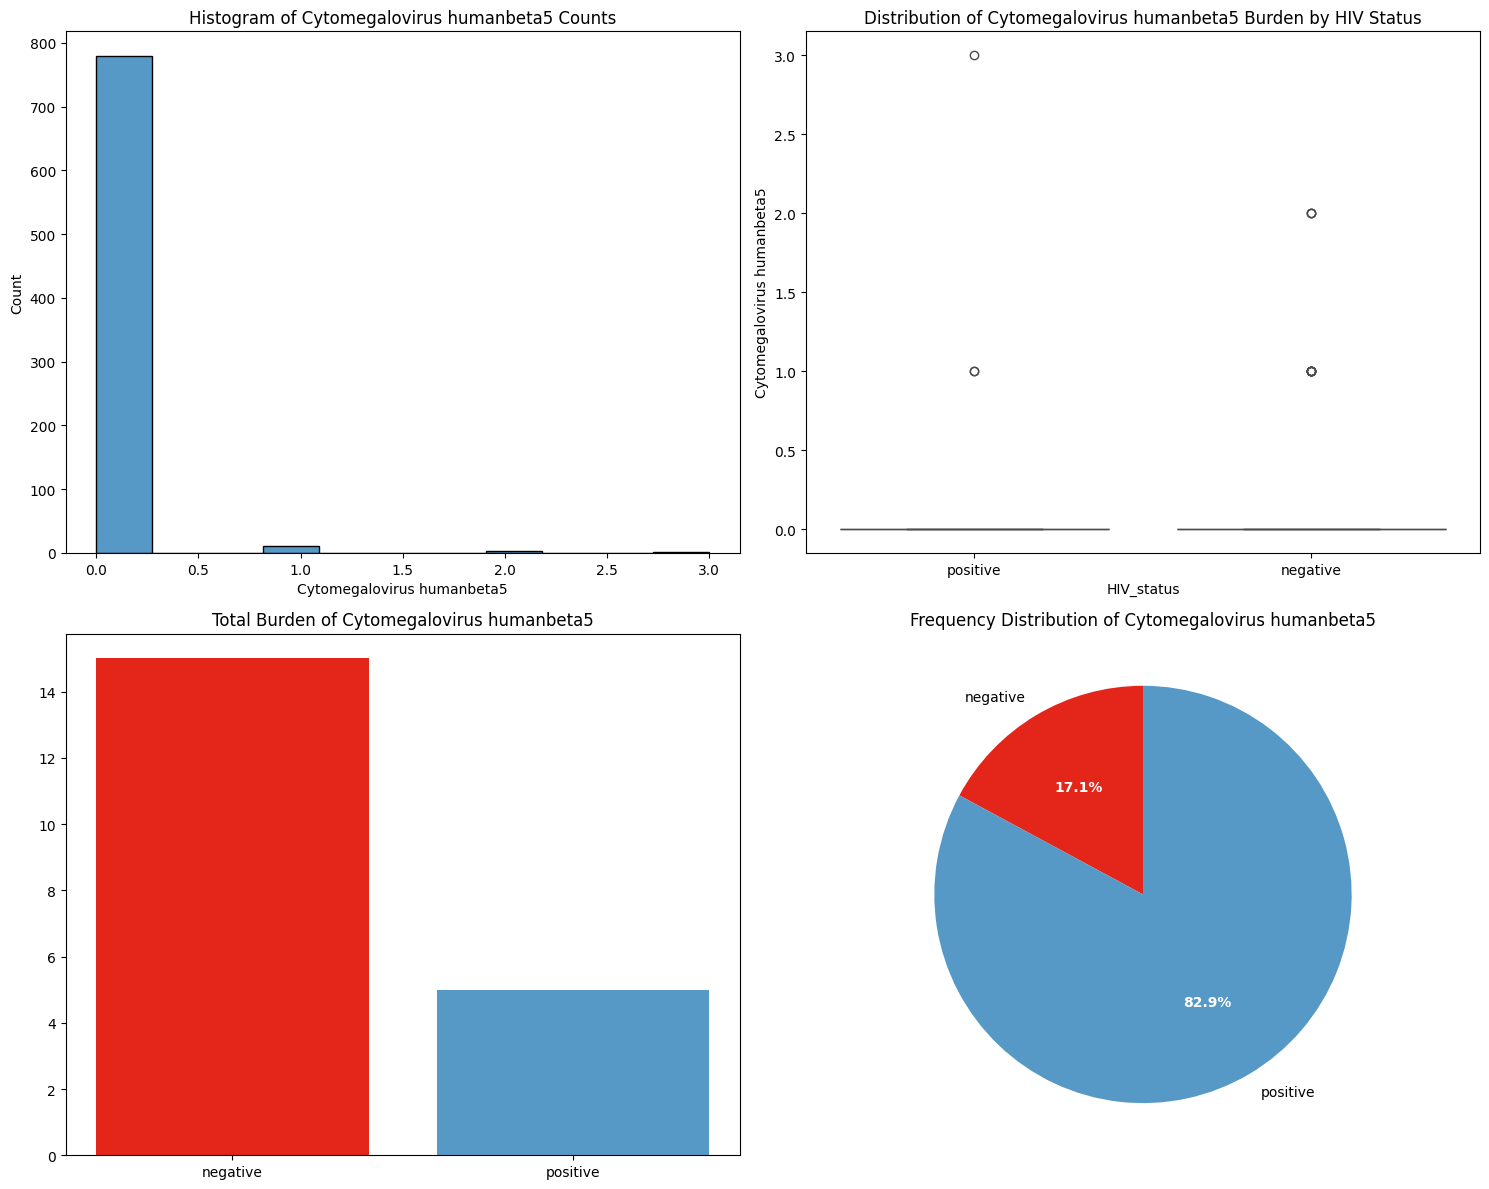

In [111]:
# Usage
# {path_to_script} {organism_name} {path_to_counts} {path_to_metadata}
%run scripts/evil_face.py "Cytomegalovirus humanbeta5" counts_viruses/counts_species_filtered.csv metadata.csv

## **Part 3. CONCLUSION**

So, if we look at the differences among the viruses, we're talking about isolated findings that don't tell us much.
- _Cytomegalovirus humanbeta5_ - in 3 samples.

This cannot say a thing. That is why it has no sense to see the detailed differences on other taxonomic levels

# **CHAPTER 4. `IonTorrent` vs `BGI`**

## **Part 0. Group data**

In [19]:
%%bash
mkdir BGI
cp reports/kraken_report_BGI/* BGI/

mkdir: cannot create directory ‘BGI’: File exists


## **Part 1. Create metadata**

Rename files. Delete `_kraken_report` from file names.

In [20]:
# Usage
# {path_to_script} {path_to_folder}
%run scripts/rename_files.py BGI/

Create `metadata.csv` based on the file names in `HIV`, `CTRL` and `BGI` folders
1. HIV_status: CTRL & BGI - negative
2. HIV_status: HIV - positive
3. Platform: HIV & CTRL - IonTorrent
4. Platform: BGI - BGI

In [21]:
# Usage
# {path_to_script} {path_to_HIV_samples} {path_to_ctrl_samples} {path_to_BGI_samples} {output_file_name}
%run scripts/create_metadata_platform.py HIV/ CTRL/ BGI/ metadata_platform.csv

Metadata file created successfully at metadata_platform.csv


## **Part 2. Create counts file**

Create folders for files groupping

In [22]:
%%bash
mkdir ALL_plus
mkdir ALL_plus/txt
mkdir ALL_plus/mpa

Copy kraken reports to the `ALL_plus/txt` folder

In [23]:
%%bash
cp CTRL/* ALL_plus/txt
cp HIV/* ALL_plus/txt
cp BGI/* ALL_plus/txt

Convert kraken reports in `ALL_plus/txt` folder to MPA format and place files in `ALL_plus/mpa` folder

In [1]:
# Usage
# {path_to_script} {path_to_txt_files} {path_to_output_mpa_files}
! ./scripts/run_kreport2mpa.sh ALL_plus/txt ALL_plus/mpa

Combine mpa files

In [112]:
# Usage
# {path_to_script} {path_to_mpa_files} {output_file_name}
%run KrakenTools/combine_mpa.py -i ALL_plus/mpa/* -o ALL_plus/COMBINED.txt

 Number of files to parse: 848
 Number of classifications to write: 4831
	4831 classifications printed


### **Part 2.1. Filter contaminants out from `ALL_plus/COMBINED.txt` file**

#### **Part 2.1.1. _Cutibacterium acnes_**

In [113]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "s__Cutibacterium_acnes"

Found keyword in line 2658
2653: d__Bacteria|p__Actinomycetota|c__Actinomycetes|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acidifaciens	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	2	0	0	0	0	0	0	1	0	2	2	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	1	0	3	1	0	1	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	1	0	0	0	0	0	0	0	0	1	0	1	0	1	0	0	0	0	1	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	

In [114]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "2658"

Lines 2658 have been deleted from ALL_plus/COMBINED.txt.


#### **Part 2.1.2. Bacteriophages**

##### **Part 2.1.2.1. _Pseudomonas phage_ PPSC2**

In [115]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4674
4669: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|o__Crassvirales|f__Intestiviridae	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [116]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4673, 4674"

Lines 4673, 4674 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.2. _Streptococcus phage_ CHPC1042 & _Escherichia phage vB EcoP_ WFI101126**

In [117]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4683
4678: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Schitoviridae	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [118]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4683, 4684, 4685"

Lines 4683, 4684, 4685 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.3. _Xanthomonas phage_ vB Xar IVIA-DoCa5 & _Stenotrophomonas phage_ vB SM ytsc ply2008005c**

In [119]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4690
4685: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Herelleviridae|g__Klumppvirus	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [120]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4689, 4690, 4694"

Lines 4689, 4690, 4694 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.4. _Brochothrix phage_ BL3 & _Staphylococcus phage_ phiRS7**

In [121]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4698
4693: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Chaseviridae|g__Loessnervirus	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [122]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4698, 4699"

Lines 4698, 4699 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.5. _Erwinia phage_ PEp14**

In [123]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4706
4701: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|g__Noxifervirus|s__Noxifervirus_noxifer	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [124]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4706"

Lines 4706 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.6. _Streptococcus phage_ CHPC1152 & _Streptococcus phage_ P7132**

In [125]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Found keyword in line 4714
4709: d__Viruses|k__Heunggongvirae|p__Uroviricota|c__Caudoviricetes|f__Straboviridae|g__Lasallevirus|s__Acinetobacter_virus_Acj61	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [126]:
# Usage
# {path_to_script} {path_to_txt_file} {line_to_delete}
%run scripts/delete_lines.py ALL_plus/COMBINED.txt "4713, 4714, 4715, 4716"

Lines 4713, 4714, 4715, 4716 have been deleted from ALL_plus/COMBINED.txt.


##### **Part 2.1.2.7. Checking if there are phages remaining**

In [127]:
# Usage
# {path_to_script} {path_to_txt_file} {query_to_find}
%run scripts/find_line.py ALL_plus/COMBINED.txt "phage"

Keyword not found in the file.


## **Part 3. Getting `counts.csv` files**

In [25]:
! mkdir counts_plus

### **Part 3.1. Parse `ALL_plus/COMBINED.txt` file to counts files on _species_ level**

In [128]:
%%bash

grep -E "s__" ALL_plus/COMBINED.txt \
| grep -v "t__" \
| grep -v "s__Homo_sapiens" \
| sed "s/^.*|//g" \
| sed "s/SRS[0-9]*-//g" \
> counts_plus/counts_species.txt

### **Part 3.2. Process counts files**

In [129]:
# Usage
# {path_to_script} {path_to_txt_file} {path_to_output_file}
%run scripts/processing_script.py ALL_plus/COMBINED.txt counts_plus/counts_species.txt

### **Part 3.3. Convert to `csv` file format**

In [130]:
# Usage
# {path_to_script} {path_to_input_file}
%run scripts/convert2csv.py counts_plus/counts_species.txt

C:\Users\iljap\OneDrive\Study\BI\Project\Research\v3.0\scripts\convert2csv.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

Data has been successfully converted and saved as 'counts_plus/counts_species.csv'.


## **Part 4. Descriptive statistics**

count      848.000000
mean       369.579009
std       1466.544081
min          0.000000
25%         58.750000
50%        118.000000
75%        258.000000
max      24864.000000
Name: total_counts, dtype: float64


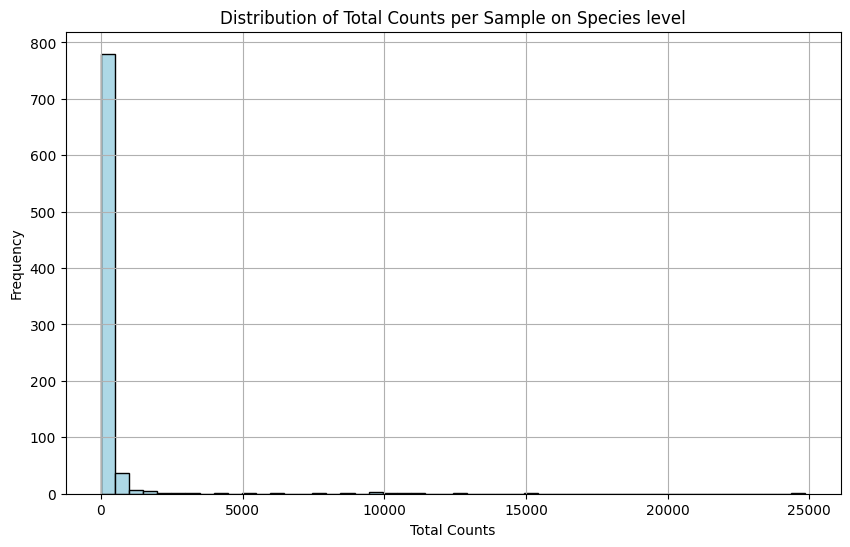

In [131]:
# Usage
# {path_to_script} {path_to_input_file} {taxonomic_level}
%run scripts/describe.py "counts_plus/counts_species.csv" Species

Wow. Impresive distribution. It is clear that something is wrong with BGI samples.

## **Part 5. Detective investigation. What's wrong with BGI samples?**

In [132]:
metadata = pd.read_csv('metadata_platform.csv')
species_counts = pd.read_csv('counts_plus/counts_species.csv')

In [133]:
# Filter the metadata for samples that have "BGI" in the "Platform" column
bgi_samples = metadata[metadata['Platform'] == 'BGI']

# Merge this filtered metadata with the species counts to get counts specifically for BGI samples
bgi_species_counts = pd.merge(bgi_samples, species_counts, left_on='sample_id', right_on='Sample_id')

# Calculate the new total number of BGI samples
total_bgi_samples = bgi_species_counts.shape[0]

# Calculate the new average number of organisms found per BGI sample
average_organisms_per_bgi_sample = (bgi_species_counts.drop(columns=['Sample_id', 'sample_id', 'HIV_status', 'Platform']) > 0).sum(axis=1).mean()

total_bgi_samples, average_organisms_per_bgi_sample

(54, 87.77777777777777)

We have 54 BGI samples<br>
And 87.78 organisms per BGI sample

In [134]:
# Calculate the number of samples each organism appears in (count nonzero occurrences)
organisms_per_sample_counts = (bgi_species_counts.drop(columns=['Sample_id', 'sample_id', 'HIV_status', 'Platform']) > 0).sum()

# Distribution thresholds
thresholds = [10, 50, 100]
organism_distribution = {f"More than {threshold} samples": (organisms_per_sample_counts > threshold).sum() for threshold in thresholds}

# Display organism distribution
organism_distribution

{'More than 10 samples': 98,
 'More than 50 samples': 0,
 'More than 100 samples': 0}

For the BGI samples, the distribution of organisms across samples is as follows:

98 organisms were detected in more than 10 samples.
None of the organisms were detected in more than 50 or 100 samples.

In [135]:
# Calculate the total counts for each organism in the BGI samples and find the most commonly found organism
bgi_organism_counts = bgi_species_counts.drop(columns=['Sample_id', 'sample_id', 'HIV_status', 'Platform']).sum().sort_values(ascending=False)
most_common_bgi_organism = bgi_organism_counts.idxmax()
most_common_bgi_organism_count = bgi_organism_counts.max()

most_common_bgi_organism, most_common_bgi_organism_count

('Komagataella phaffii', 132295)

There are 132295 occurences of _Komagataella phaffii_??!! WHAT??!! Wow! Let us see other top organisms of BGI samples...

In [136]:
# Top 5 most detected organisms
top_5_organisms = bgi_organism_counts.nlargest(5)

# Top 5 least detected organisms but appeared at least once
least_5_organisms = bgi_organism_counts[bgi_organism_counts > 0].nsmallest(5)

top_5_organisms, least_5_organisms

(Komagataella phaffii       132295
 Pseudomonas lundensis        3721
 Acinetobacter johnsonii      2692
 Aeromonas salmonicida        2515
 Lactobacillus crispatus      2203
 dtype: int64,
 Sphingomonas sp. NIBR02145         1
 Clostridium beijerinckii           1
 Herbaspirillum seropedicae         1
 Sphingobacterium sp. BN32          1
 Neopusillimonas aromaticivorans    1
 dtype: int64)

In [137]:
# Filter samples that have detected Komagataella phaffii (counts greater than 0)
samples_with_komagataella = bgi_species_counts[bgi_species_counts['Komagataella phaffii'] > 0]['sample_id']

samples_with_komagataella.tolist()

['20230512_861',
 '20230512_863',
 '20230512_867',
 '20230512_868',
 '20230512_872',
 '20230512_875',
 '20230512_877',
 '20230610_1019',
 '20230610_1071',
 '20230610_1072',
 '20230610_1073',
 '20230610_1076',
 '20230610_1079',
 '20230610_1080',
 '20230610_1091',
 '20230610_1092',
 '20230610_1094',
 '20230610_1095',
 '20230905_1740',
 '20230905_1741',
 '20230905_1744',
 '20230905_1745',
 '20230905_1746',
 '20230905_1747',
 '20230905_1748',
 '20230905_1754',
 '20230905_1757']

In [138]:
# Get the length of the list of samples with Komagataella phaffii
len(samples_with_komagataella)

27

So... 54 BGI samples. 27 (50%) of them have _Komagataella phaffii_ IN EXTREMELY HIGH NUMBER OF OCCERENCESES!!!!!!! Library of BGI samples is just a library full of contaminants. There is completely no sense to clean this data out, because contaminants have squeezed out any sense of looking at this data further.